<a href="https://colab.research.google.com/github/OozyGrub/Assignment-3-MVC-MVP-MVVM/blob/master/nasdaq100_trading_algorithm.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Import

In [1]:
!pip install yfinance -q
!pip install matplotlib -q
!pip install seaborn -q
!pip install --upgrade -q ta

     |████████████████████████████████| 6.3MB 4.5MB/s 


In [2]:
import yfinance as yf
import numpy as np
import pandas as pd
import warnings
warnings.filterwarnings("ignore")
from IPython.display import Markdown, display
def printmd(string):
    display(Markdown(string))

## Preparation

In [3]:
# configuration
period = '2y'

In [4]:
# msft = yf.Ticker("MSFT")
# aapl = yf.Ticker("AAPL")
# get historical market data
# hist = msft.history(period = period)
# hist.plot()
# for hist in tickers:
#     hist.plot()

# stocks = ["MSFT", "AAPL", "AAME", "AACG", "ACIW", "ACRX"]

stocks = ["AAPL","ADBE","ADI","ADP","ADSK",
"AEP","ALGN","ALXN","AMAT","AMD","AMGN","AMZN",
"ANSS","ASML","ATVI","AVGO","BIDU",
"BIIB","BKNG","CDNS","CDW","CERN","CHKP","CHTR",
"CMCSA",
"COST",
"CPRT",
"CSCO",
"CSX",
"CTAS",
"CTSH",
"DLTR",
"DOCU",
"DXCM",
"EA",
"EBAY",
"EXC",
"FAST",
"FB",
"FISV",
"FOX",
"FOXA",
"GILD",
"GOOG",
"GOOGL",
"IDXX",
"ILMN",
"INCY",
"INTC",
"INTU",
"ISRG",
"JD",
"KDP",
"KHC",
"KLAC",
"LRCX",
"LULU",
"MAR",
"MCHP",
"MDLZ",
"MELI",
"MNST",
"MRNA",
"MRVL",
"MSFT",
"MTCH",
"MU",
"MXIM",
"NFLX",
"NTES",
"NVDA",
"NXPI",
"OKTA",
"ORLY",
"PAYX",
"PCAR",
"PDD",
"PEP",
"PTON",
"PYPL",
"QCOM",
"REGN",
"ROST",
"SBUX",
"SGEN",
"SIRI",
"SNPS",
"SPLK",
"SWKS",
"TCOM",
"TEAM",
"TMUS",
"TSLA",
"TXN",
"VRSK",
"VRSN",
"VRTX",
"WBA",
"WDAY",
"XEL",
"XLNX",
"ZM"]
num_stocks = len(stocks)
stock_dict = dict(enumerate(stocks))
idx_to_stock = dict([(val, key) for key, val in stock_dict.items()])

tickers = [yf.Ticker(stock).history(period=period) for stock in stocks]

In [5]:
# for key, val in msft.info.items():
#     print(f"{key}: {val}")

In [6]:
# hist['Close'].plot(figsize=(16, 9))

In [7]:
from ta import add_all_ta_features
from ta.utils import dropna

def with_features(x):
    return add_all_ta_features(x, open="Open", high="High", low="Low", close="Close", volume="Volume")

df = []
for ticker in tickers:
    try:
        x = with_features(ticker)
        df.append(x)
    except:
        print(ticker)

In [8]:
df[0][['momentum_tsi', 'Close']].info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 505 entries, 2019-05-22 to 2021-05-21
Data columns (total 2 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   momentum_tsi  468 non-null    float64
 1   Close         505 non-null    float64
dtypes: float64(2)
memory usage: 11.8 KB


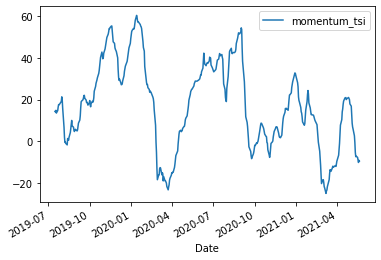

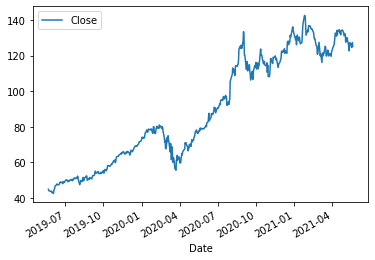

In [9]:
df[0][['momentum_tsi']].plot()
df[0][['Close']].plot()

## Multiple Strategy

In [53]:
from datetime import timedelta, date
from dateutil import relativedelta

# configs
decimal_display = 2
start_date = date(2019, 10, 1)
end_date = date(2021, 5, 1)
debug = False
initial_balance = 100.00


def calculate_position_balance(at_date):
    prices = [df[j]['Close'].get(to_date_key(at_date)) if 
              df[j]['Close'].get(to_date_key(at_date)) else 
              find_nearest_price(j, at_date) 
              for j in range(num_stocks)]
    return np.dot(position, prices)

def daterange(start_date, end_date):
    for n in range(int((end_date - start_date).days)):
        yield start_date + timedelta(n)

def to_date_key(x):
    return x.strftime("%Y-%m-%d")

def buy(amount, price):
    return amount / price

def sell(amount, price):
    return amount * price

def find_nearest_price(i, date):
    while True:
        date -= timedelta(1)
        if df[i]['Close'].get(to_date_key(date)):
            return df[i]['Close'].get(to_date_key(date))

def find_nearest_tsi(i, date):
    while True:
        date -= timedelta(1)
        if df[i]['momentum_tsi'].get(to_date_key(date)):
            return df[i]['momentum_tsi'].get(to_date_key(date))

def get_tsi_data(date):
    return [(key, x['momentum_tsi'].get(to_date_key(date)) if
             x['momentum_tsi'].get(to_date_key(date)) else
             find_nearest_tsi(key, date)) for
            key, x in enumerate(df)]

In [54]:
from itertools import permutations, product

month_period_params = [1, 2]
num_stock_hold_params = [5, 10]
sell_threshold_params = [[1.25, 1.50, 1.75]]
sell_ratio_params = [[.2, .2, .2], [.2, .3, .4], [.1, .2, .3]]
# cut_loss
cut_loss_threshold_params = [.9, .8]
# max_price
stop_loss_threshold_params = [.9, .8, .7, .6]

product_params = list(product(month_period_params,
                   num_stock_hold_params,
                   sell_threshold_params,
                   sell_ratio_params,
                   cut_loss_threshold_params,
                   stop_loss_threshold_params))

product_params_size = len((product_params))

In [55]:
from tqdm.auto import tqdm, trange

0 -> total balance: 168.2


1 -> total balance: 181.33


2 -> total balance: 194.48


3 -> total balance: 198.2


4 -> total balance: 168.2


5 -> total balance: 181.33


6 -> total balance: 194.48


7 -> total balance: 198.2


8 -> total balance: 168.68


9 -> total balance: 181.72


10 -> total balance: 194.9


11 -> total balance: 198.62


12 -> total balance: 168.68


13 -> total balance: 181.72


14 -> total balance: 194.9


15 -> total balance: 198.62


16 -> total balance: 169.29


17 -> total balance: 181.49


18 -> total balance: 194.28


19 -> total balance: 198.23


20 -> total balance: 169.29


21 -> total balance: 181.49


22 -> total balance: 194.28


23 -> total balance: 198.23


24 -> total balance: 167.03


25 -> total balance: 169.72


26 -> total balance: 183.65


27 -> total balance: 191.27


28 -> total balance: 167.03


29 -> total balance: 169.72


30 -> total balance: 183.65


31 -> total balance: 191.27


32 -> total balance: 167.24


33 -> total balance: 169.89


34 -> total balance: 183.83


35 -> total balance: 191.45


36 -> total balance: 167.24


37 -> total balance: 169.89


38 -> total balance: 183.83


39 -> total balance: 191.45


40 -> total balance: 167.55


41 -> total balance: 169.51


42 -> total balance: 183.28


43 -> total balance: 191.04


44 -> total balance: 167.55


45 -> total balance: 169.51


46 -> total balance: 183.28


47 -> total balance: 191.04


48 -> total balance: 142.55


49 -> total balance: 177.61


50 -> total balance: 167.66


51 -> total balance: 170.47


52 -> total balance: 142.55


53 -> total balance: 177.61


54 -> total balance: 167.66


55 -> total balance: 170.47


56 -> total balance: 142.88


57 -> total balance: 177.1


58 -> total balance: 167.18


59 -> total balance: 169.98


60 -> total balance: 142.88


61 -> total balance: 177.1


62 -> total balance: 167.18


63 -> total balance: 169.98


64 -> total balance: 143.27


65 -> total balance: 180.65


66 -> total balance: 170.13


67 -> total balance: 172.79


68 -> total balance: 143.27


69 -> total balance: 180.65


70 -> total balance: 170.13


71 -> total balance: 172.79


72 -> total balance: 156.21


73 -> total balance: 174.96


74 -> total balance: 164.78


75 -> total balance: 171.14


76 -> total balance: 156.21


77 -> total balance: 174.96


78 -> total balance: 164.78


79 -> total balance: 171.14


80 -> total balance: 156.35


81 -> total balance: 174.6


82 -> total balance: 164.44


83 -> total balance: 170.78


84 -> total balance: 156.35


85 -> total balance: 174.6


86 -> total balance: 164.44


87 -> total balance: 170.78


88 -> total balance: 157.44


89 -> total balance: 177.55


90 -> total balance: 167.03


91 -> total balance: 173.39


92 -> total balance: 157.44


93 -> total balance: 177.55


94 -> total balance: 167.03


95 -> total balance: 173.39



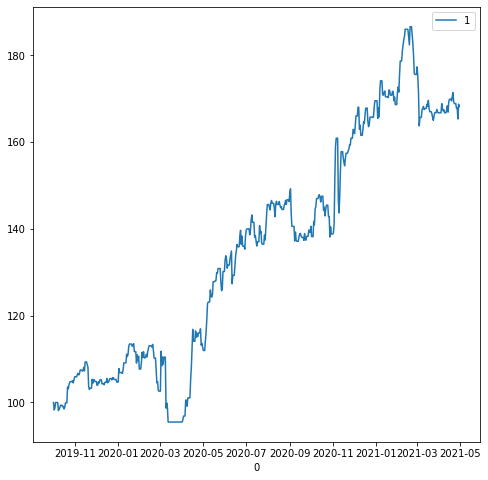

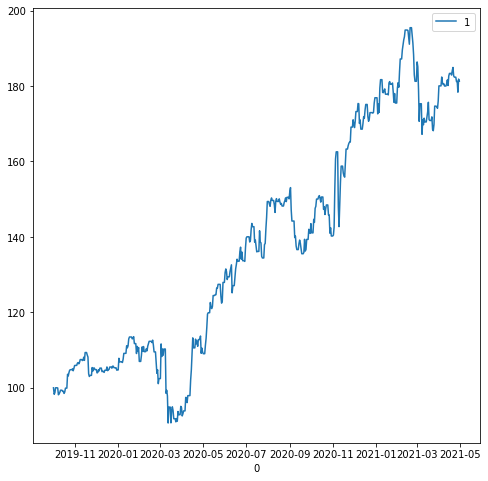

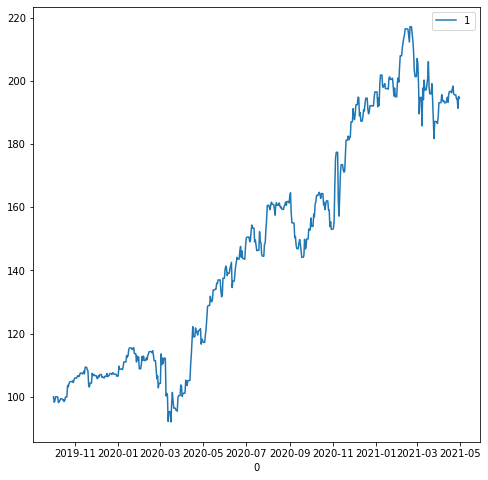

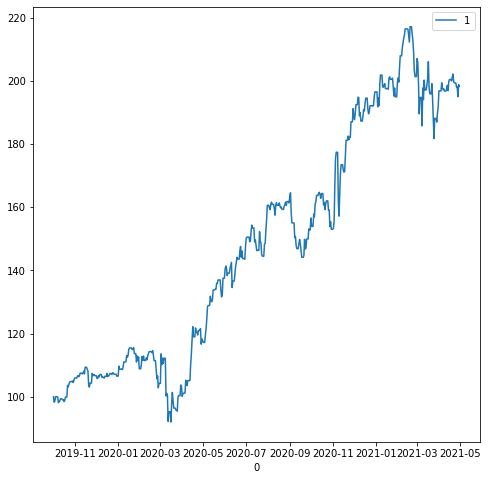

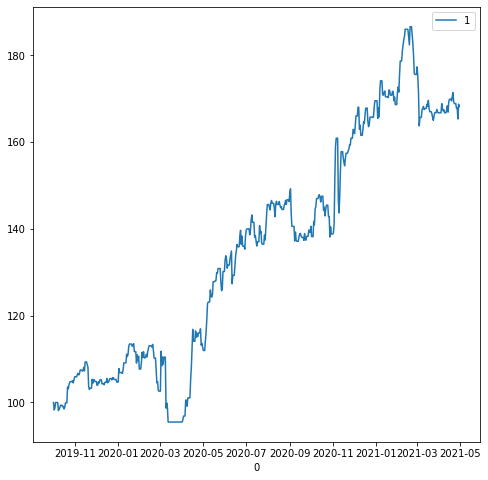

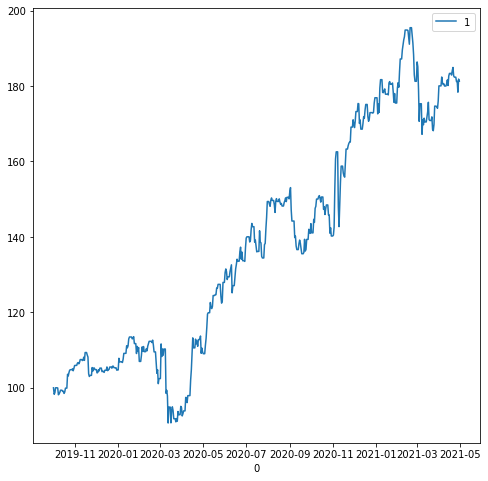

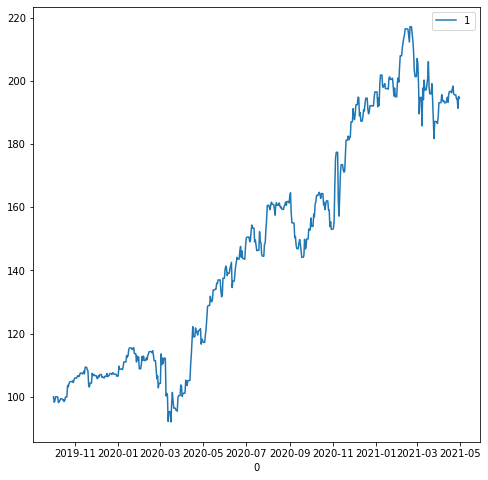

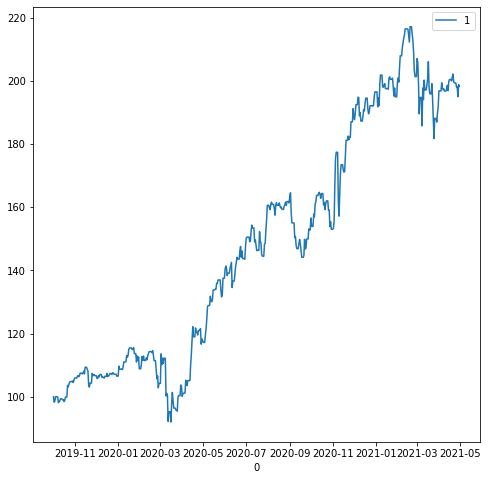

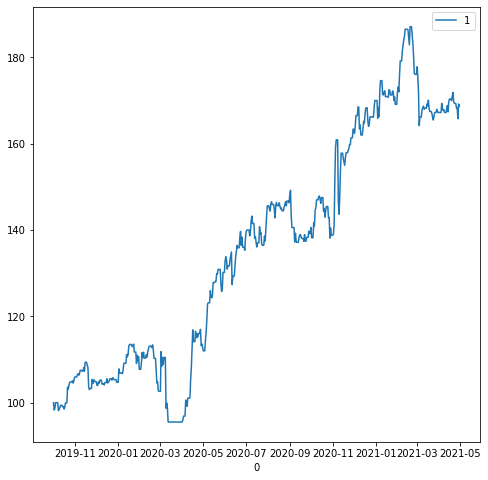

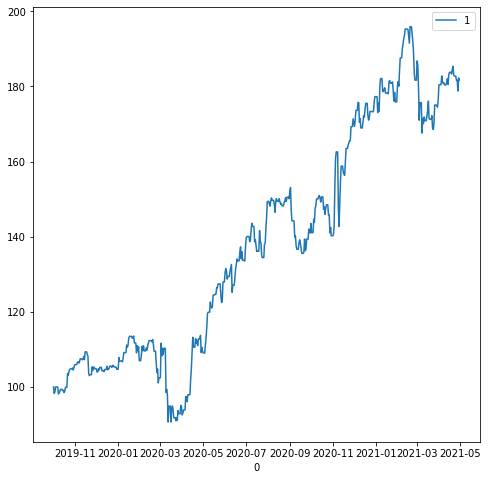

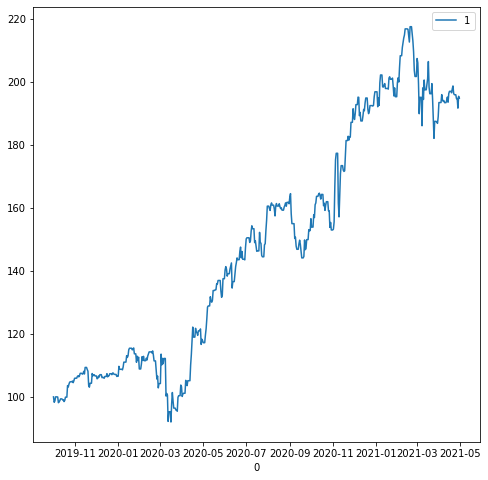

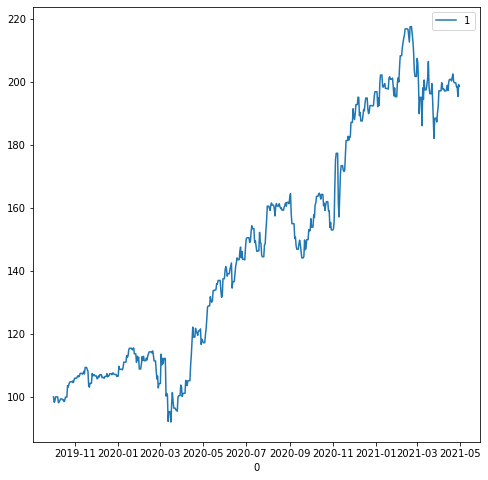

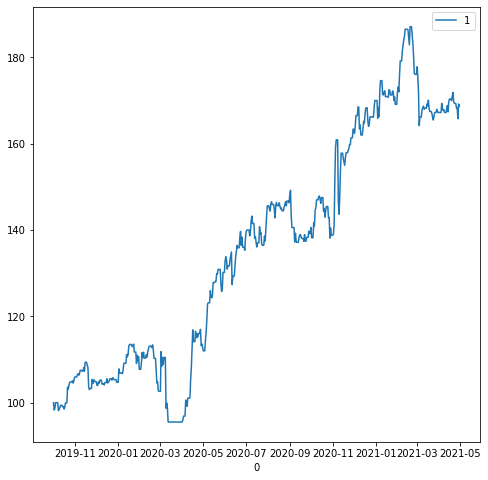

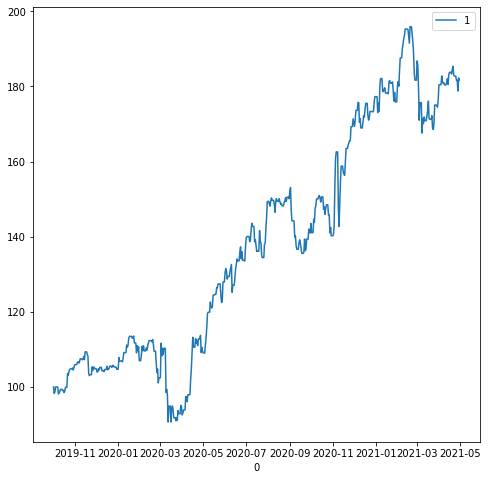

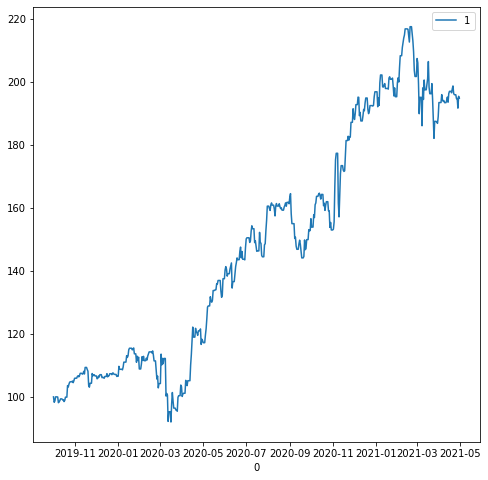

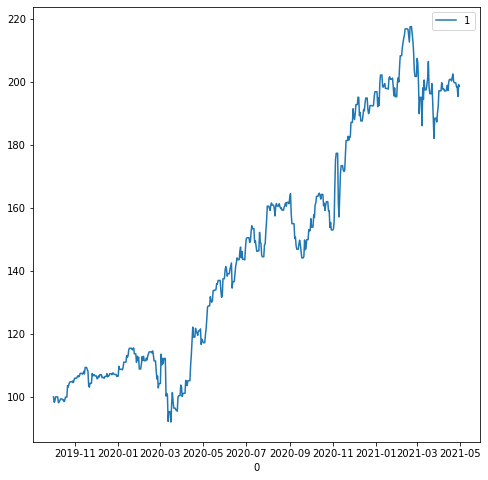

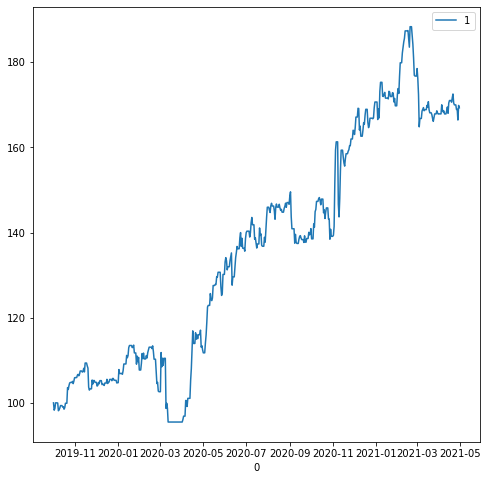

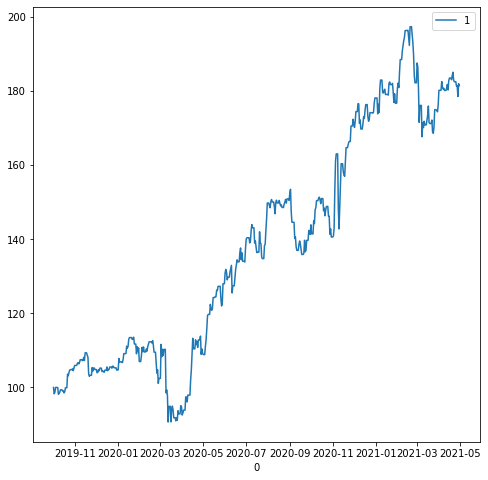

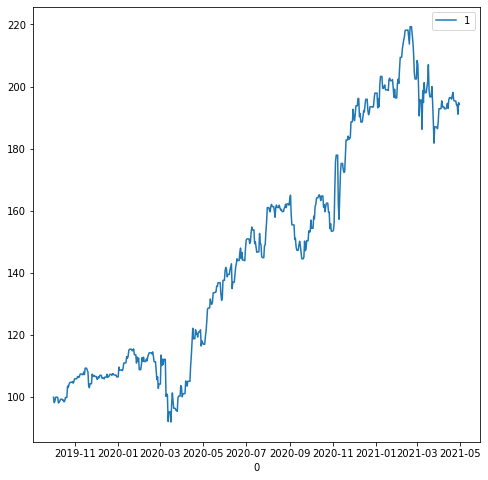

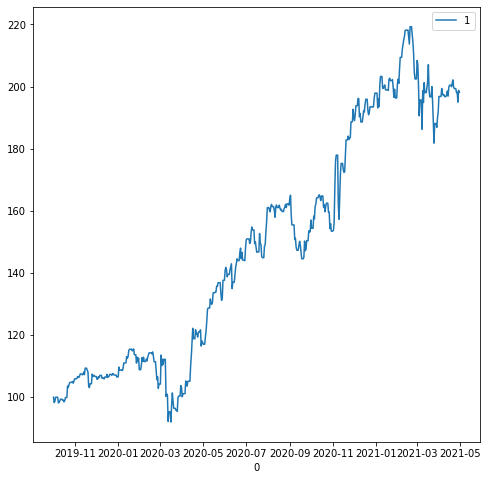

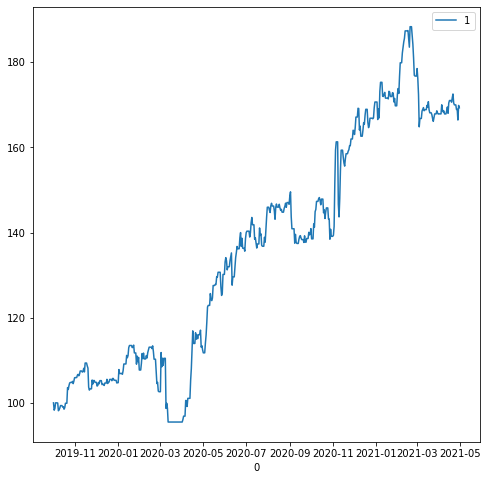

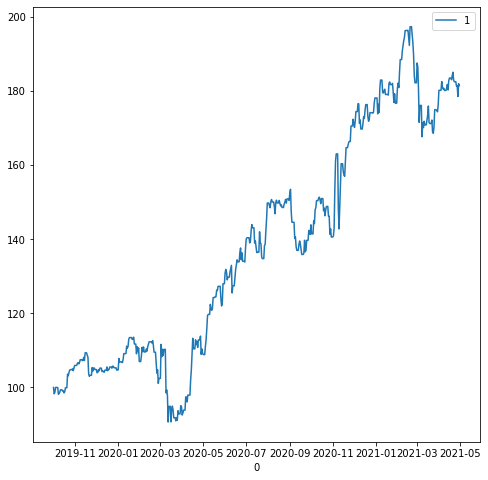

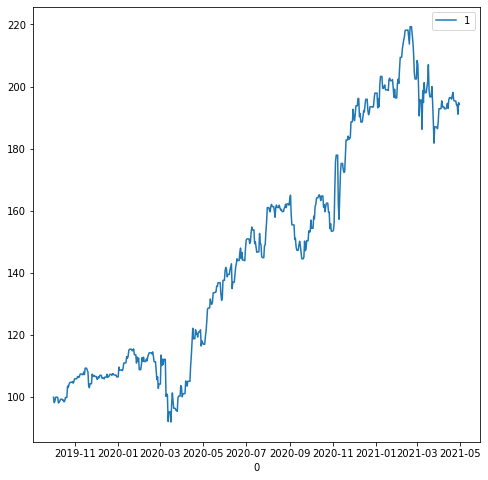

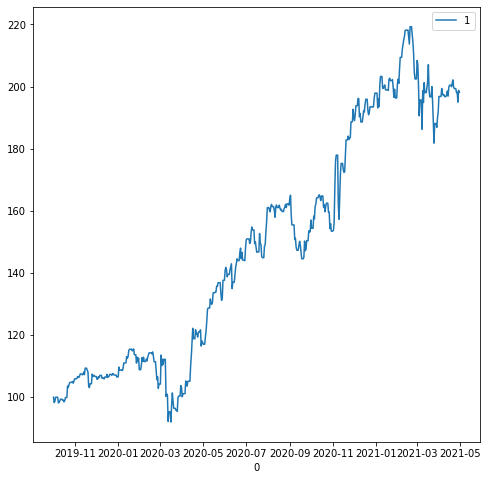

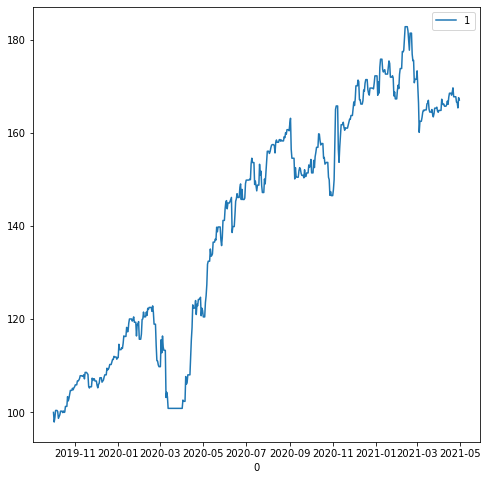

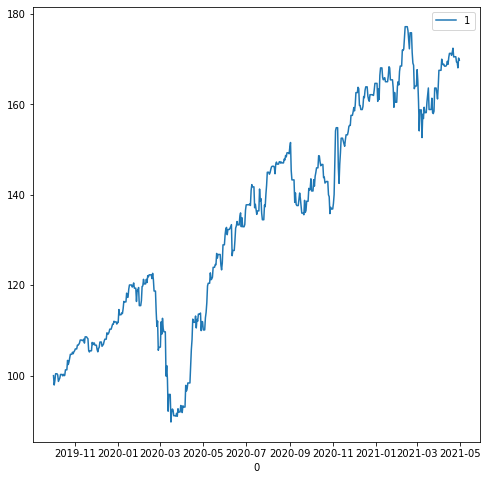

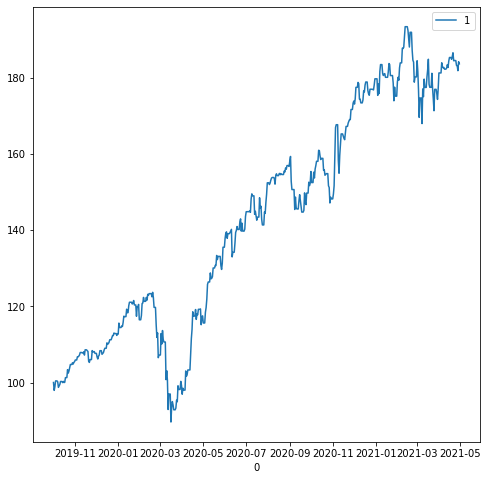

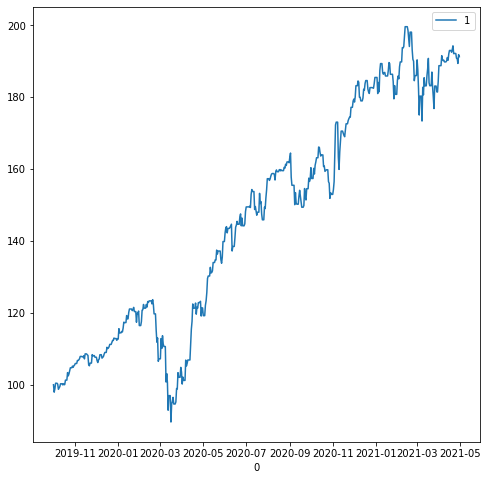

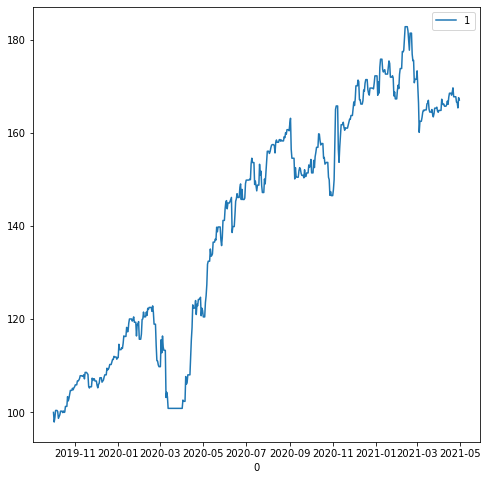

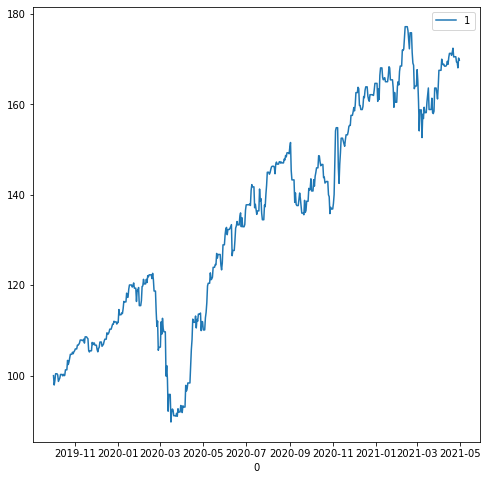

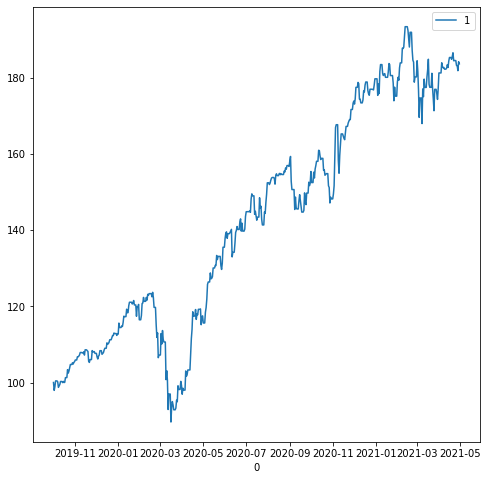

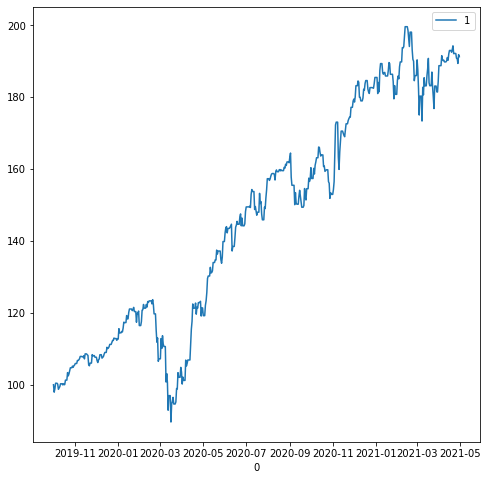

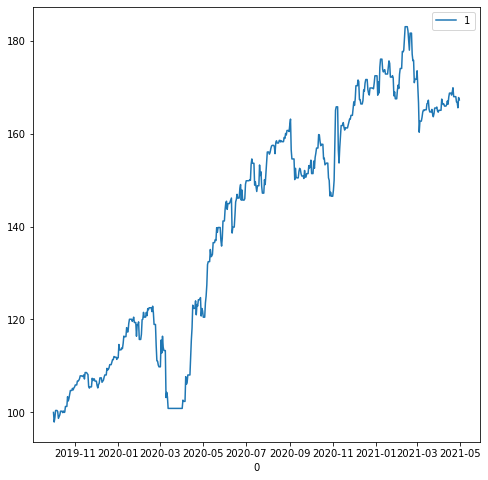

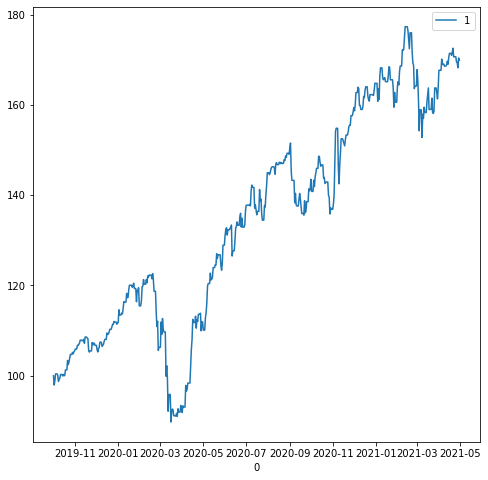

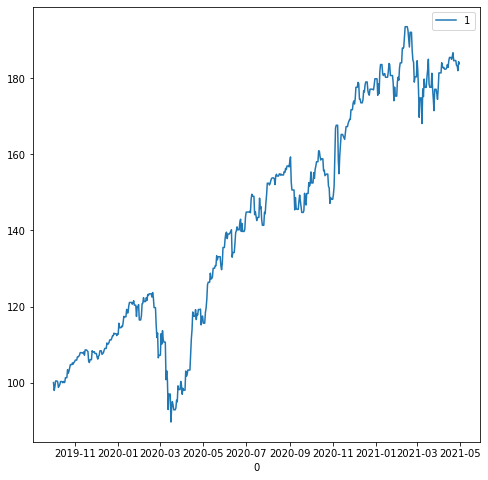

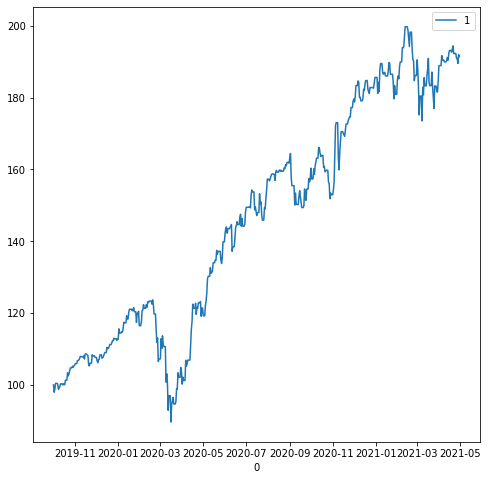

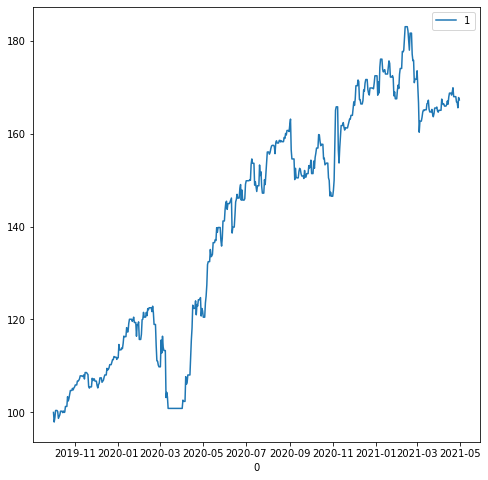

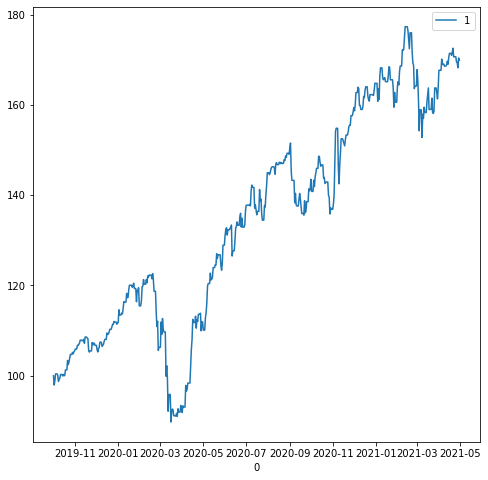

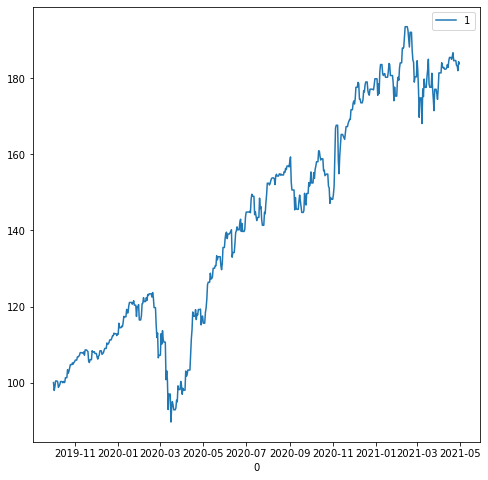

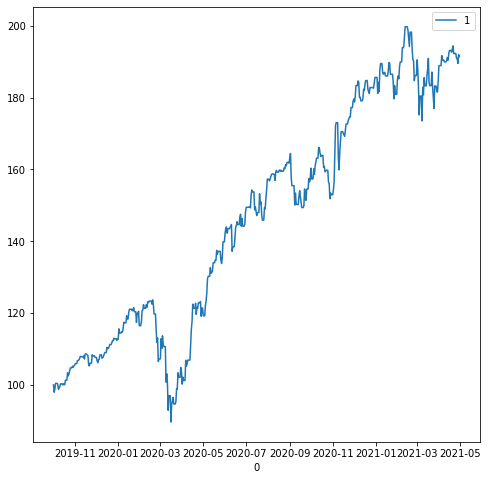

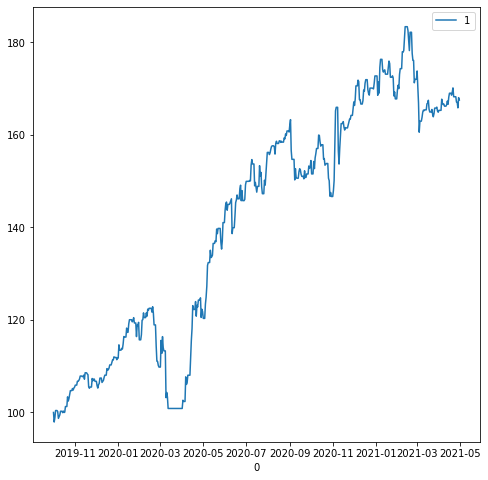

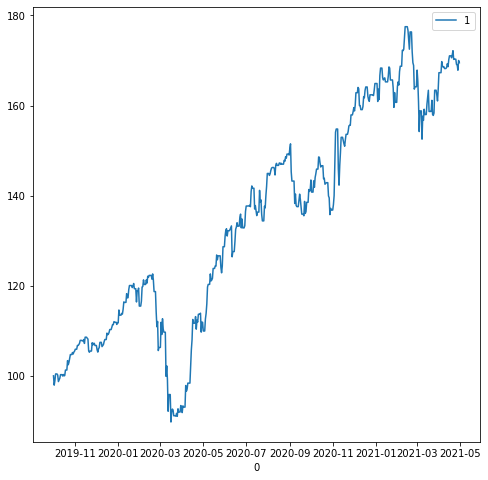

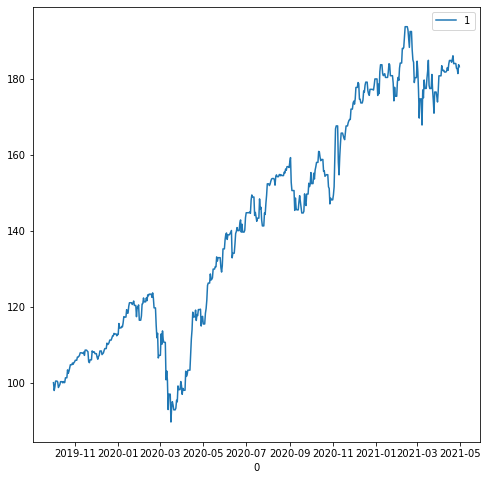

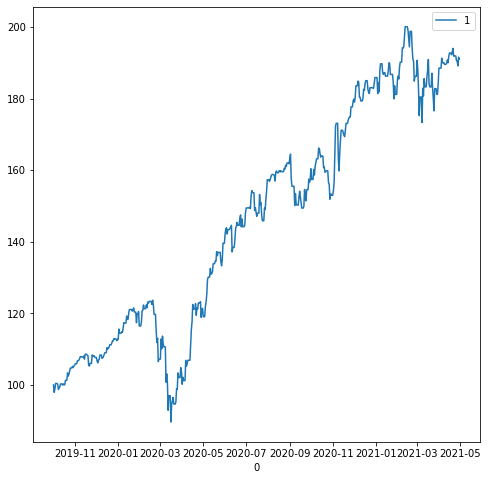

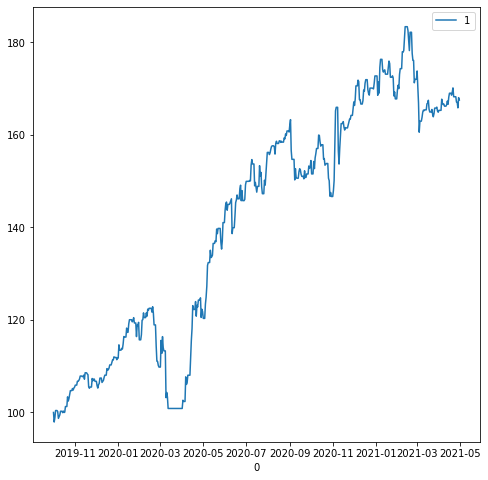

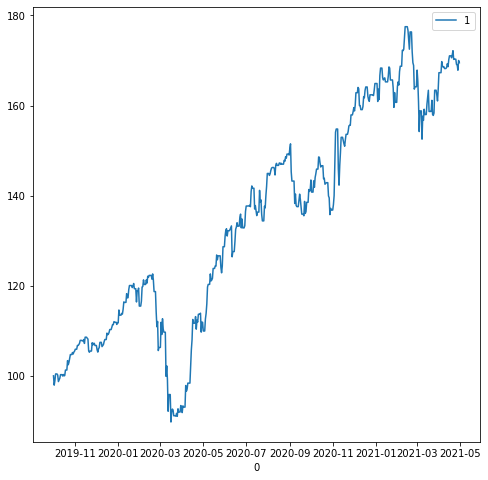

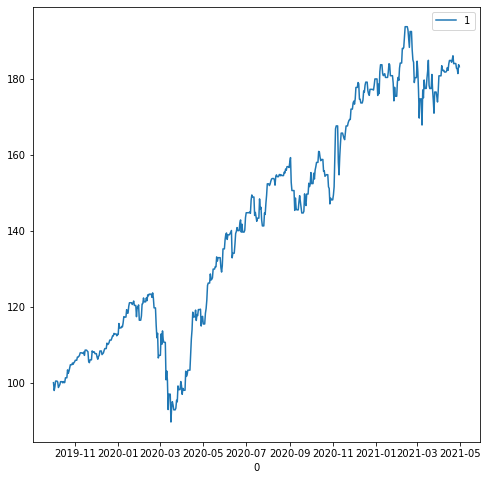

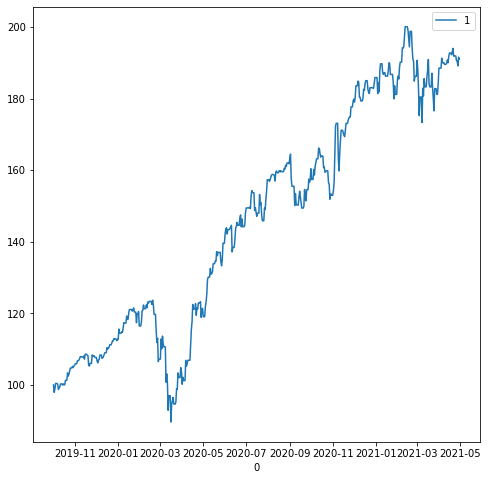

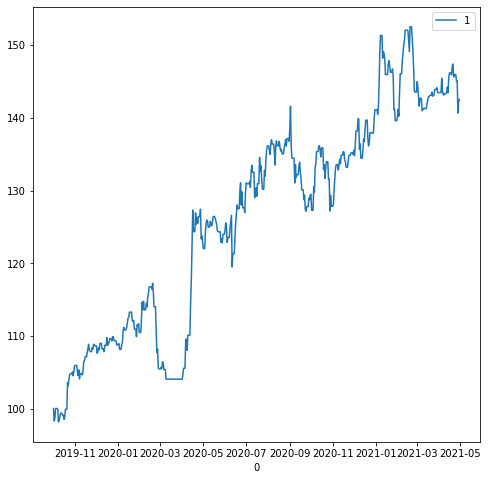

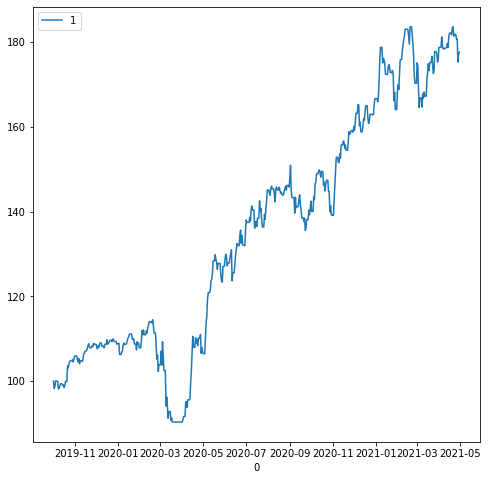

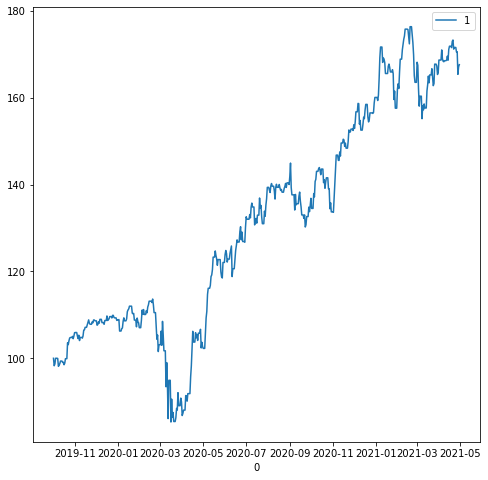

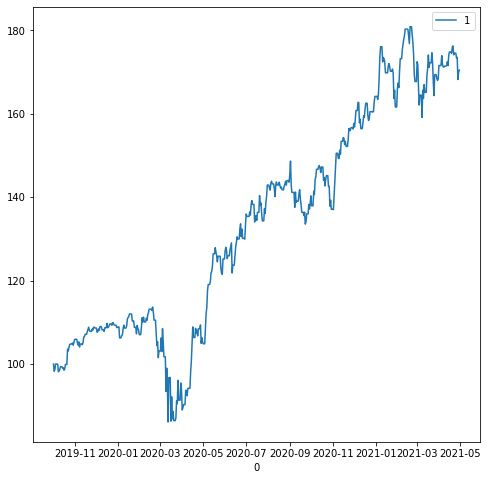

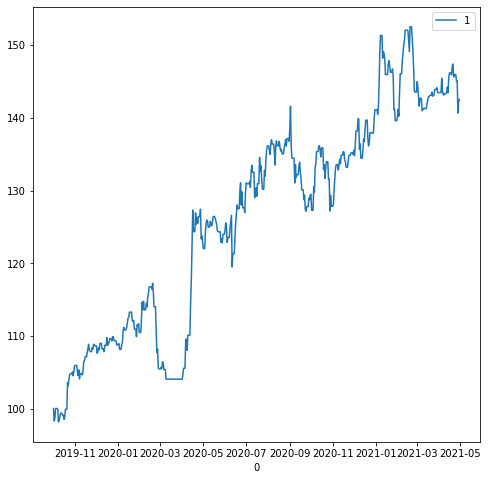

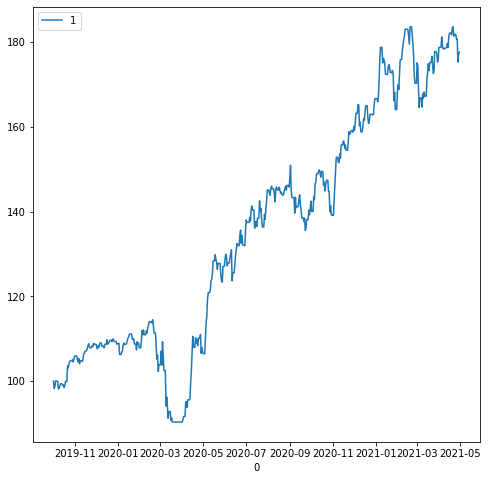

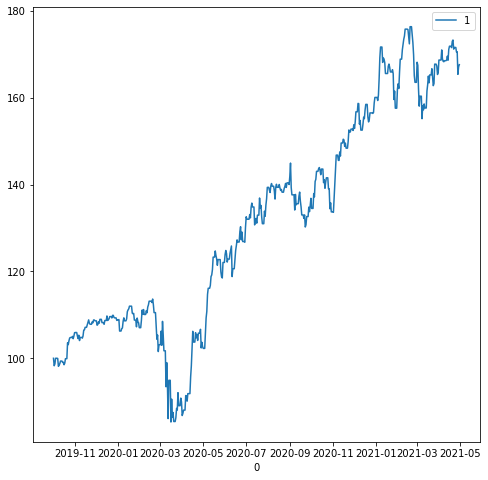

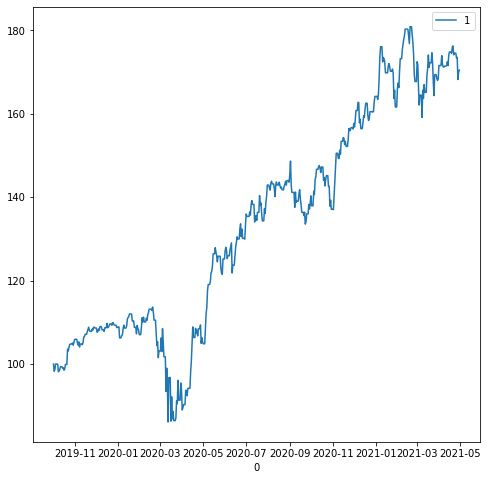

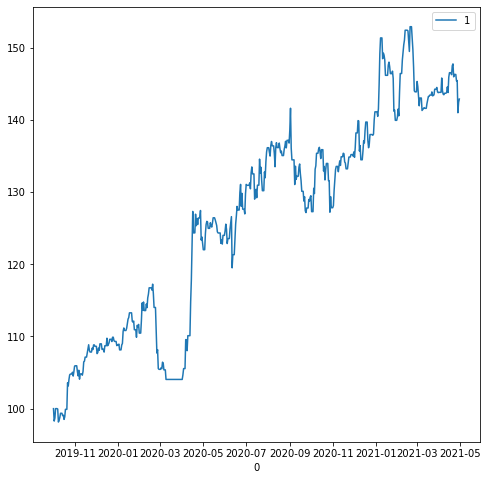

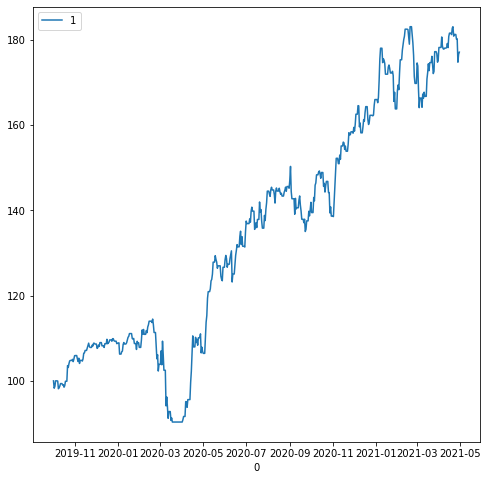

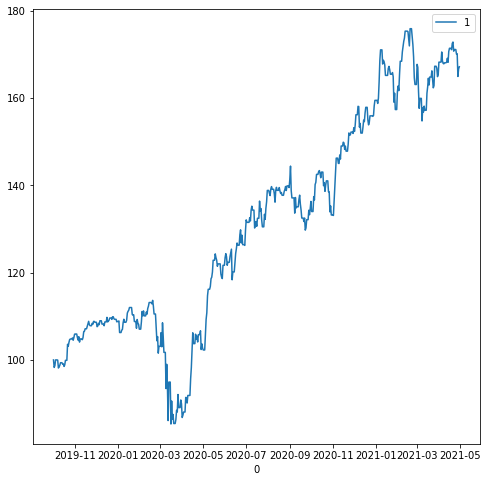

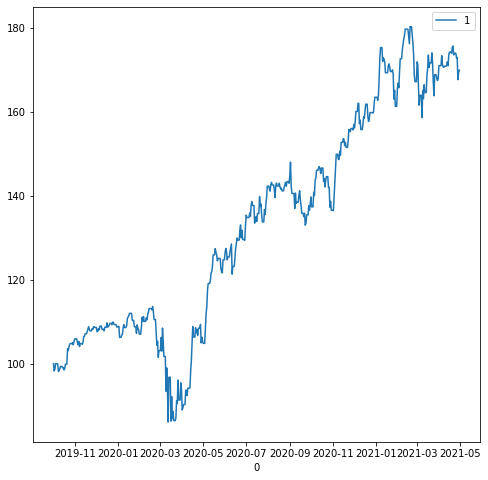

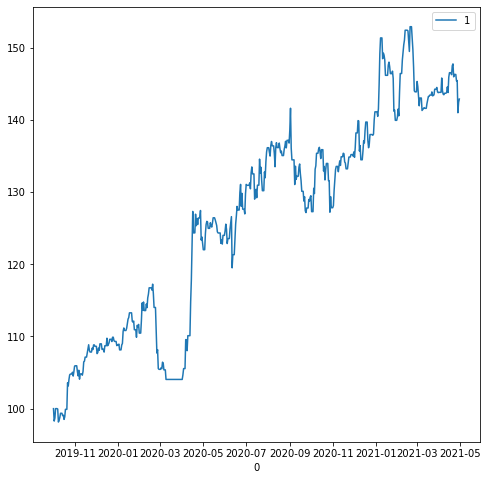

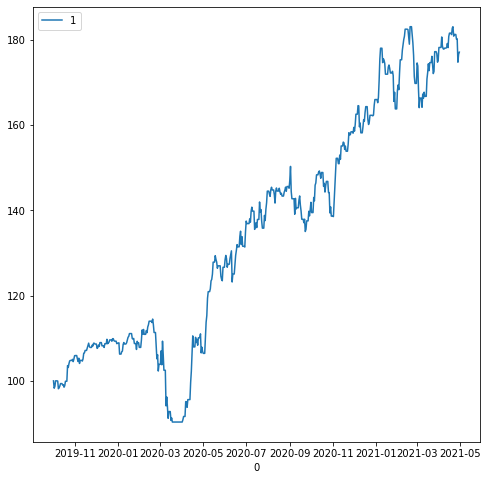

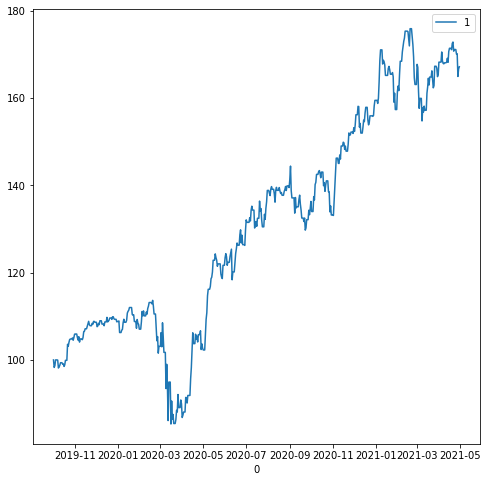

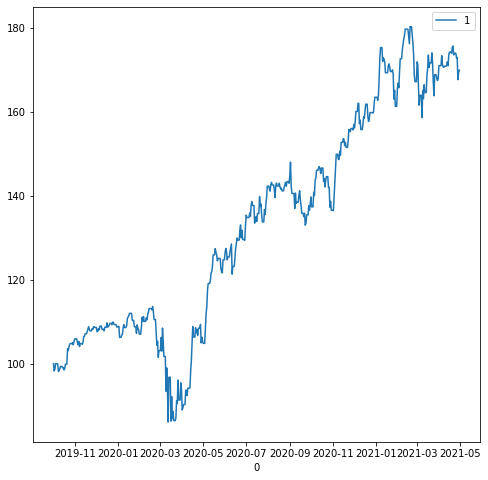

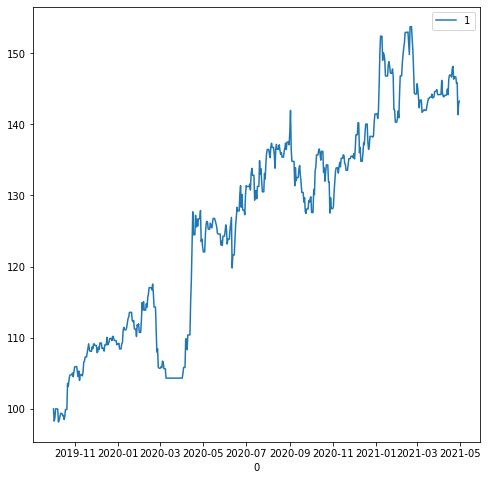

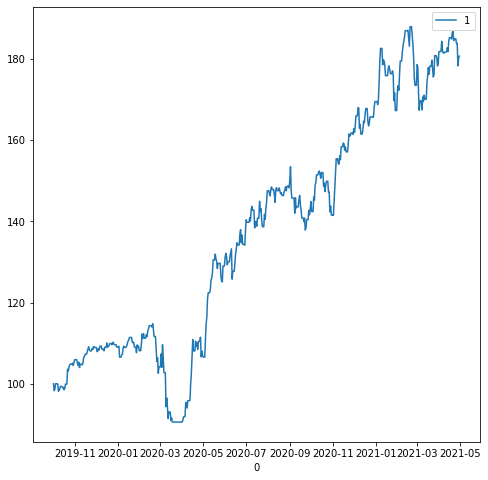

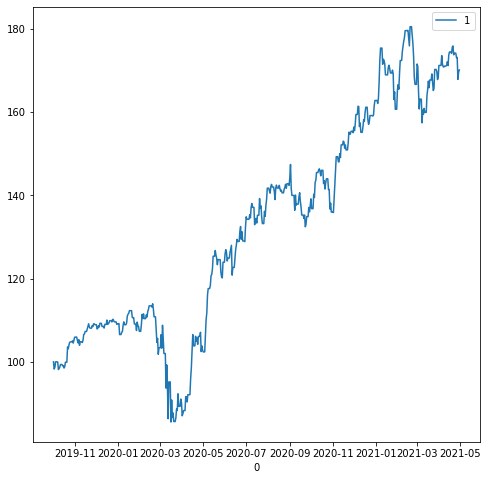

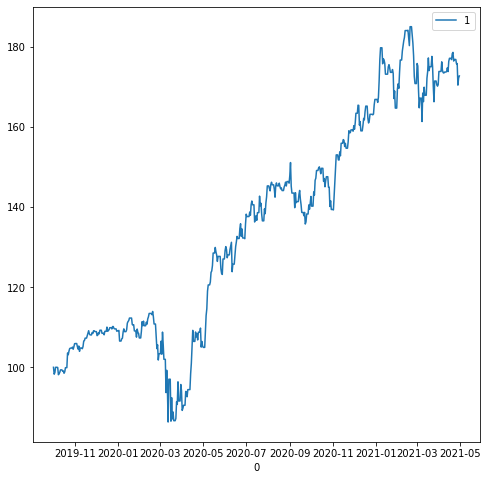

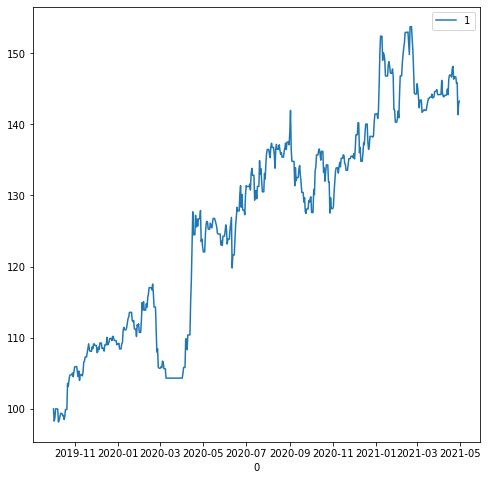

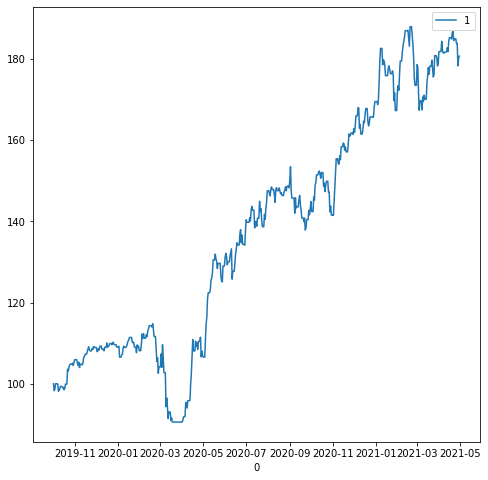

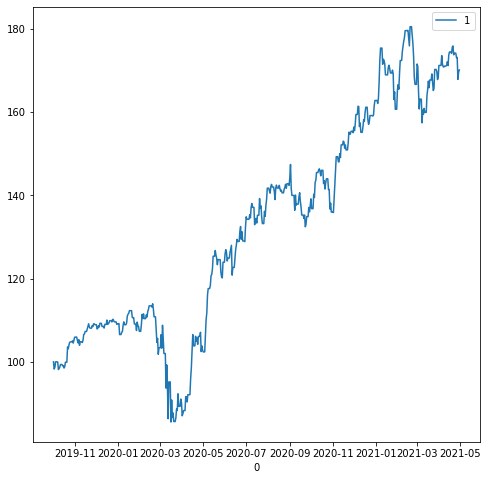

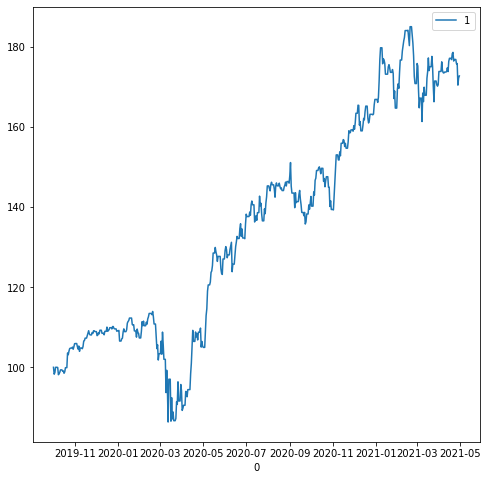

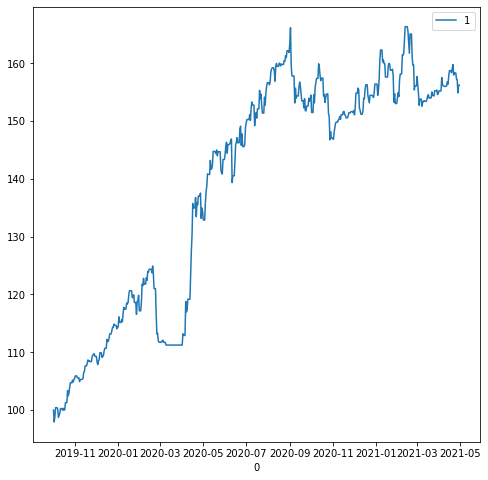

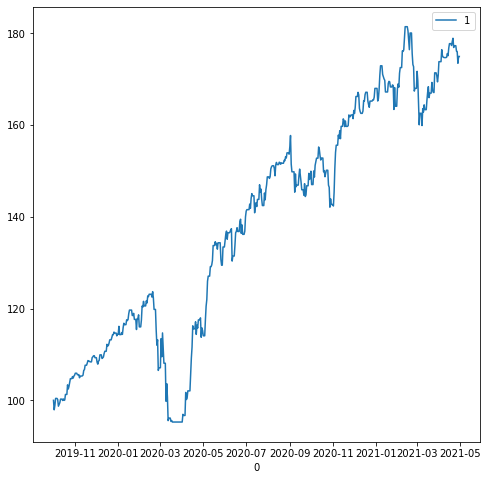

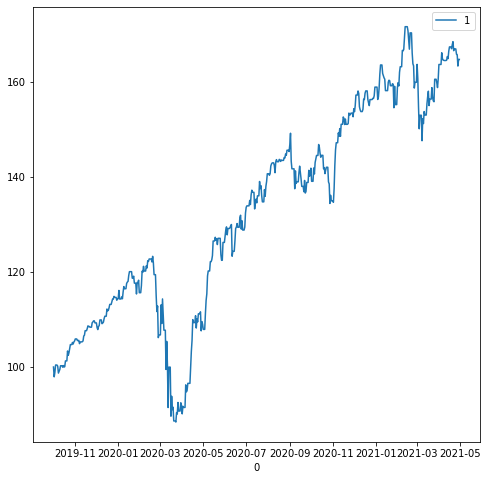

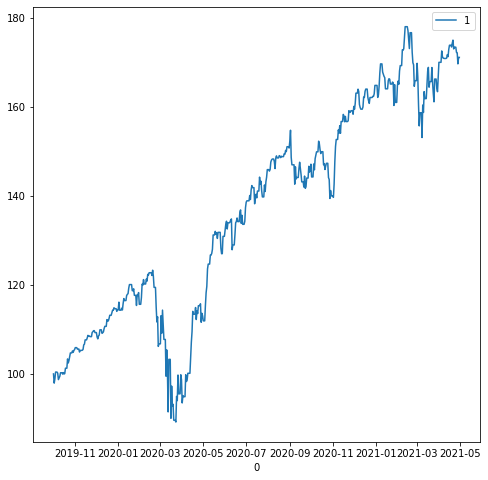

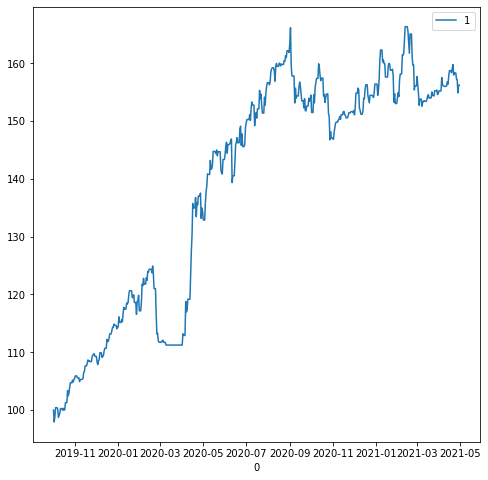

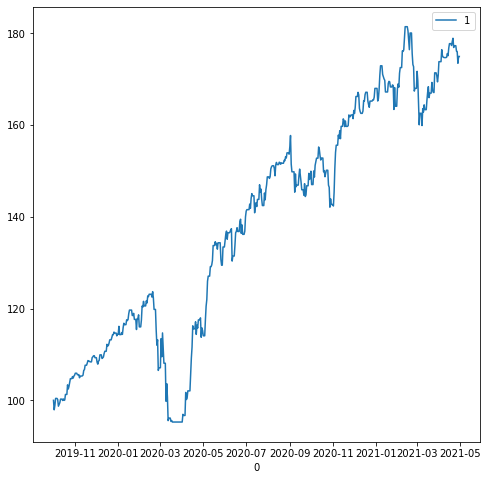

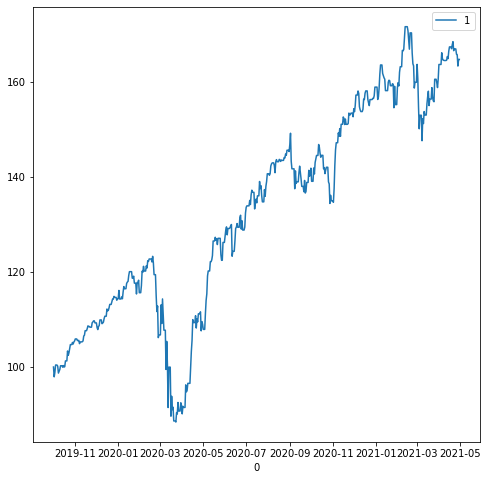

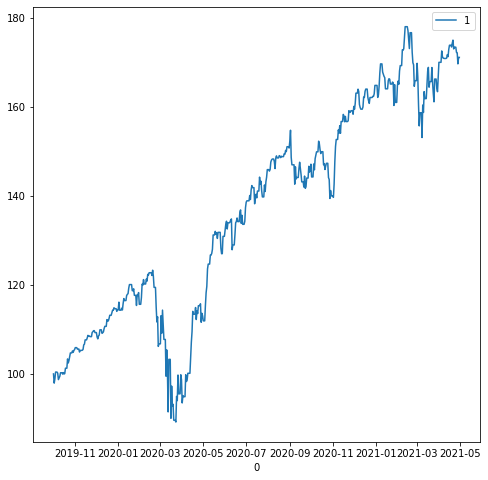

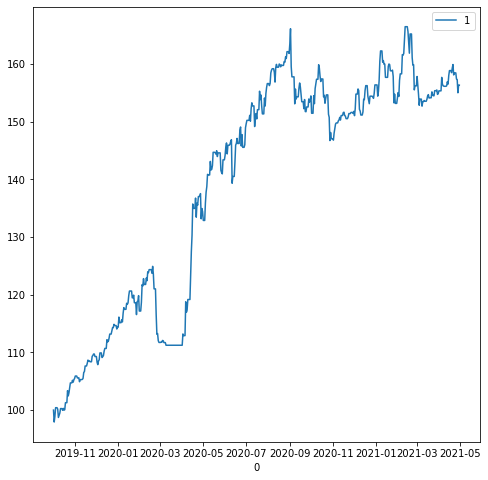

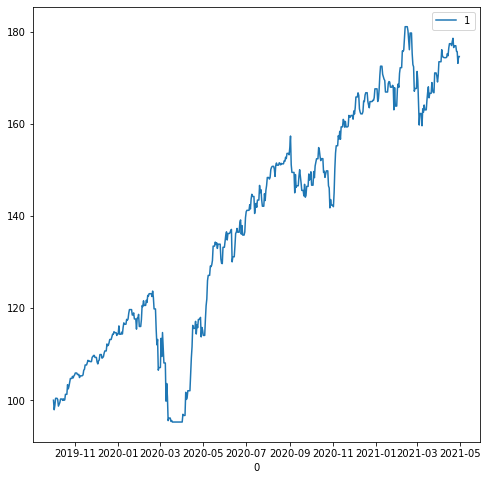

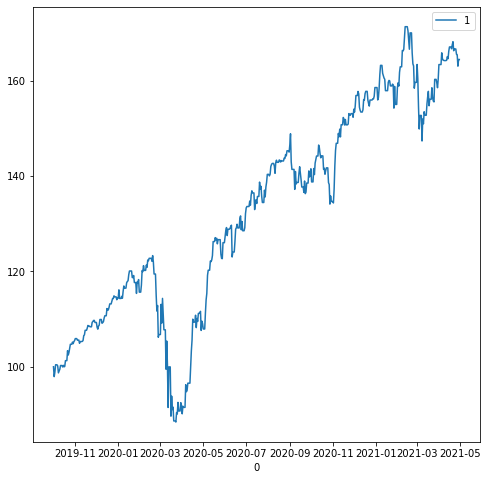

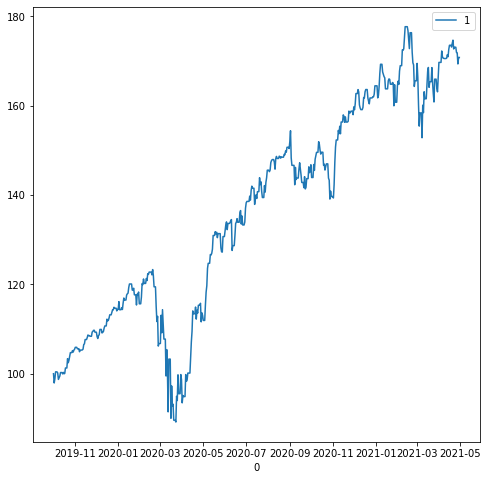

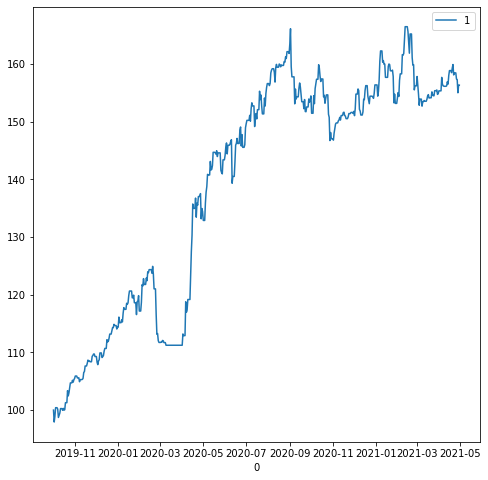

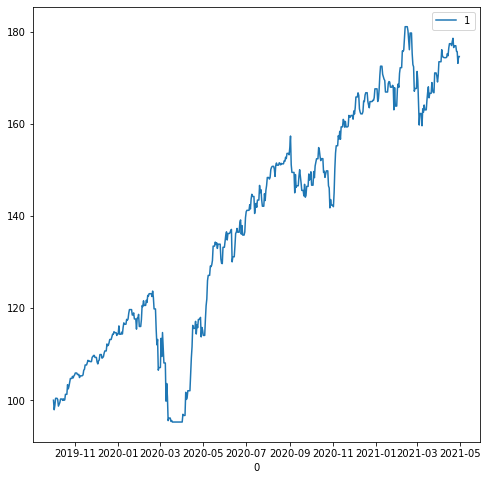

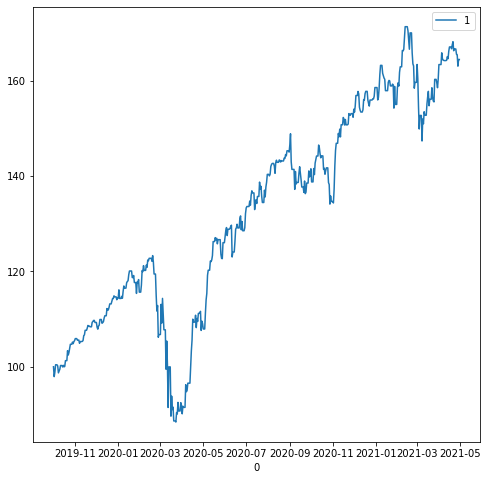

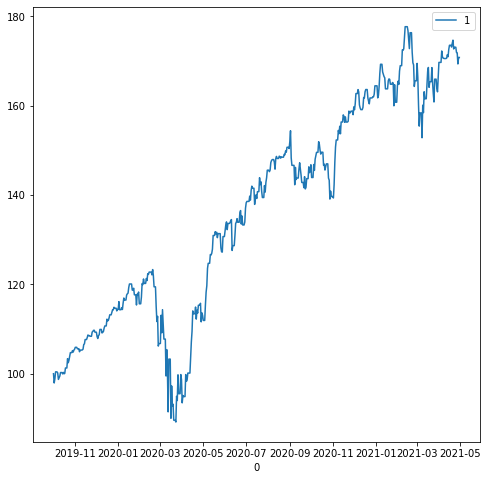

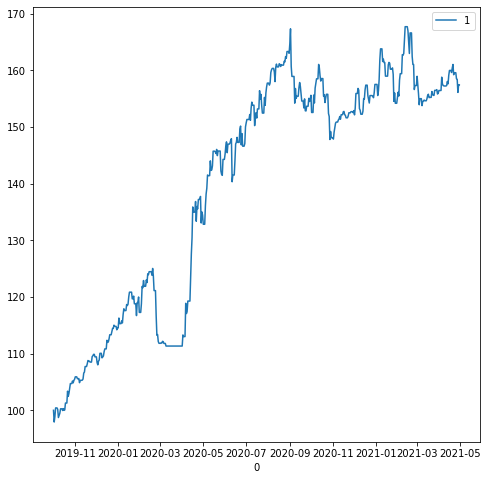

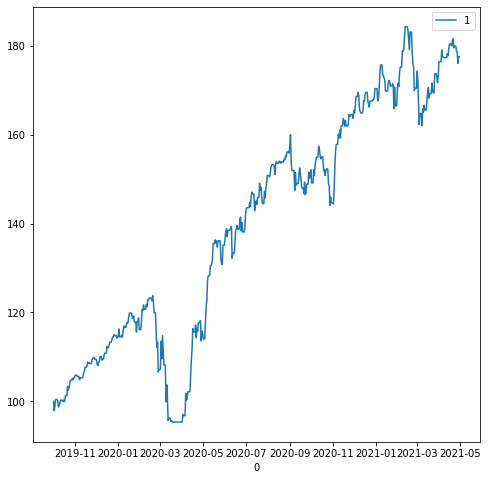

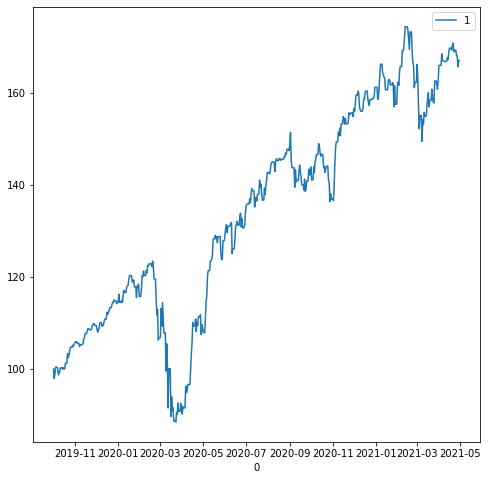

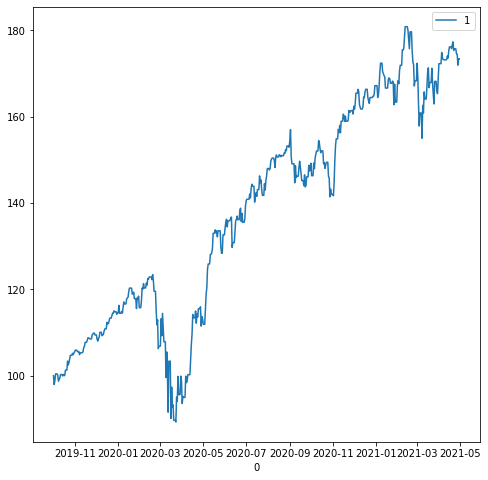

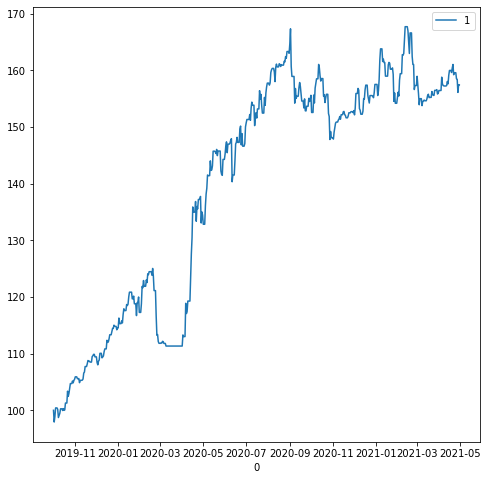

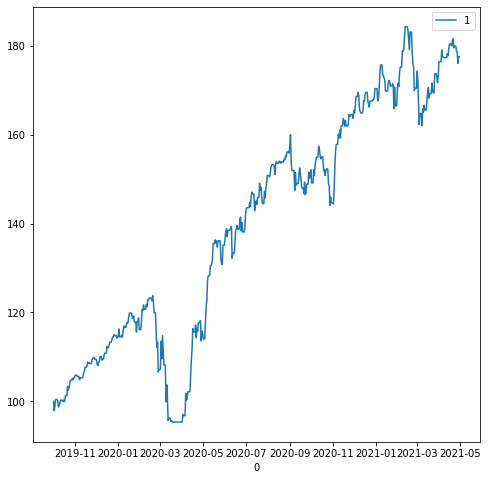

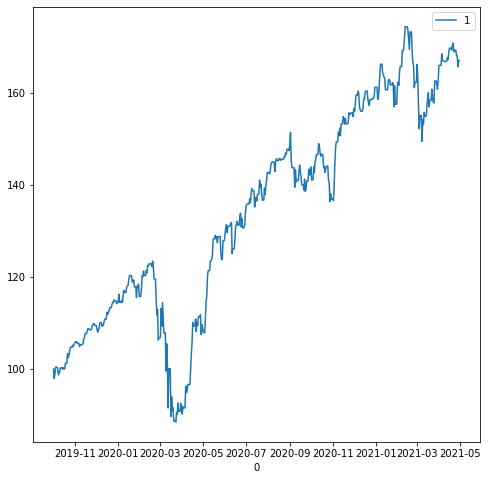

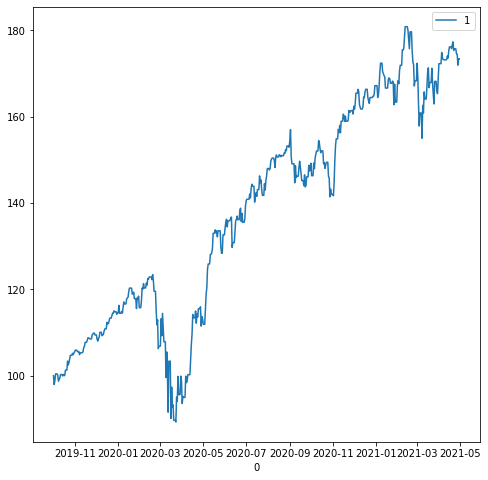

In [56]:
results = [] # (idx, balance)[]

for idx in trange(product_params_size, desc='product_params'):
    # params
    month_period = product_params[idx][0]
    num_stock_hold = product_params[idx][1]
    sell_threshold = product_params[idx][2]
    sell_ratio = product_params[idx][3]
    cut_loss_threshold = product_params[idx][4]
    stop_loss_threshold = product_params[idx][5]

    # initial vars
    total_balance = initial_balance
    position = [0.00] * num_stocks
    state = [0] * num_stocks
    buy_at = [0.00] * num_stocks
    max_price = [0.00] * num_stocks
    selected_stock = []
    acc_total_balances = []
    month_count = 0
    trading_token = 0

    def hit_sell_threshold(i, price, buy_price):
        return price >= buy_price * sell_threshold[i]

    def hit_cut_loss_threshold(price, buy_price):
        return price <= buy_price * cut_loss_threshold

    def hit_stop_loss_threshold(price, max_price):
        return price <= max_price * stop_loss_threshold
        
    for single_date in tqdm(list(daterange(start_date, end_date)),leave=False, desc='date'):
        date_key = to_date_key(single_date)

        # Trading period
        if single_date.day == 1:
            if month_count % month_period == 0:
                trading_token = 1
            month_count += 1

        if trading_token == 1:
            trading_token = 0
            # select stock by top tsi
            tsi_data = get_tsi_data(single_date)
            tsi_data.sort(key=lambda x:-x[1])
            top_stock = tsi_data[5: num_stock_hold + 5]
            selected_stock = list(map(lambda x : x[0], top_stock))
            if debug:
                printmd(f"Month {month_count}")
                print(list(map(lambda x : (stock_dict[x[0]], x[1]), top_stock)))

            # sell all if not top
            for i in range(num_stocks):
                price = df[i]['Close'].get(date_key) if df[i]['Close'].get(date_key) else find_nearest_price(i, single_date)
                if position[i] > 0.0 and (i not in selected_stock):
                    amount = position[i]
                    total_balance += sell(amount, price)
                    state[i] = 0
                    buy_at[i] = 0
                    max_price[i] = 0
                    position[i] = 0
                    if debug:
                        print(f"{date_key} 🧧 sell {stock_dict[i]} at: {round(price, decimal_display)}, amount: {round(amount, decimal_display)}, total_balance: {round(total_balance, decimal_display)}")

            # buy all top
            partial_balance = total_balance / num_stock_hold
            if partial_balance > 0.0:
                for i in selected_stock:
                    price = df[i]['Close'].get(date_key) if df[i]['Close'].get(date_key) else find_nearest_price(i, single_date)
                    amount = buy(partial_balance, price)
                    total_balance -= partial_balance
                    position[i] += amount
                    buy_at[i] = price
                    max_price[i] = price
                    state[i] = 0
                    if debug:
                        print(f"{date_key} 🟢 buy {stock_dict[i]} at: {round(price, decimal_display)}, amount: {round(amount, decimal_display)}, total_balance: {round(total_balance, decimal_display)}")

        # Watch stock price
        for i in selected_stock:
            price = df[i]['Close'].get(date_key) if df[i]['Close'].get(date_key) else find_nearest_price(i, single_date)
            max_price[i] = max(price, max_price[i])
            if position[i] > 0.0:
                # sell
                if state[i] < len(sell_threshold) and hit_sell_threshold(state[i], price, buy_at[i]):
                    amount = position[i] * sell_ratio[state[i]]
                    total_balance += sell(amount, price)
                    position[i] -= amount
                    state[i] += 1
                    symbol = "🔴" * state[i]
                    if debug:
                        # print(position)
                        print(f"{date_key} {symbol} sell {stock_dict[i]} at: {round(price, decimal_display)}, amount: {round(amount, decimal_display)}, total_balance: {round(total_balance, decimal_display)}")

                # stop loss
                elif hit_stop_loss_threshold(price, max_price[i]):
                    amount = position[i]
                    total_balance += sell(amount, price)
                    buy_at[i] = 0.0
                    position[i] = 0.0
                    state[i] += 1
                    if debug:
                        # print(position)
                        print(f"{date_key} 🔥 stop_loss {stock_dict[i]} at: {round(price, decimal_display)}, amount: {round(amount, decimal_display)}, total_balance: {round(total_balance, decimal_display)}")
                # cut loss
                # elif hit_cut_loss_threshold(price, buy_at[i]):
                #     amount = position[i]
                #     total_balance += sell(amount, price)
                #     # buy_at[i] = 0.0
                #     position[i] = 0.0
                #     state[i] += 1
                #     if debug:
                #         # print(position)
                #         print(f"{date_key} 🔥 cut_loss {stock_dict[i]} at: {round(price, decimal_display)}, amount: {round(amount, decimal_display)}, total_balance: {round(total_balance, decimal_display)}")
        acc_total_balances.append((single_date, total_balance + calculate_position_balance(single_date)))
        # print(calculate_position_balance(single_date))

    pd.set_option('display.max_rows', 100)
    acc_total_balance_df = pd.DataFrame(acc_total_balances)
    acc_total_balance_df = acc_total_balance_df.set_index(0)
    acc_total_balance_df.plot(figsize=(8, 8))

    total_balance += calculate_position_balance(end_date)

    # Saving results
    results.append((idx, total_balance))

    if debug: print("-------- 📈 Summary --------")
    print(f"{idx} -> total balance: {round(total_balance, decimal_display)}")

count     96.000000
mean     174.080081
std       13.703982
min      142.552588
25%      167.470094
50%      170.963677
75%      182.112714
max      198.624890
Name: 1, dtype: float64

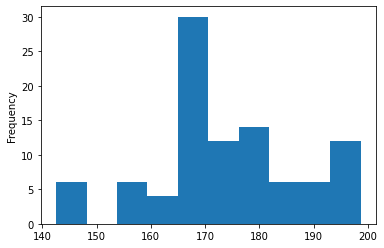

In [57]:
result_df = pd.DataFrame(results)
result_df[1].plot.hist(bins=10)
result_df[1].describe()

In [58]:
results.sort(key=lambda x:x[1], reverse=True)
for result in results[:5]:
    idx = result[0]
    params = product_params[idx]

    month_period = params[0]
    num_stock_hold = params[1]
    sell_threshold = params[2]
    sell_ratio = params[3]
    cut_loss_threshold = params[4]
    stop_loss_threshold = params[5]

    print(f"{idx}   total balance : {round(result[1], 100)}")
    print(f"        month_period: {month_period}")
    print(f"        num_stock_hold: {num_stock_hold}")
    print(f"        sell_threshold: {sell_threshold}")
    print(f"        sell_ratio: {sell_ratio}")
    print(f"        cut_loss_threshold: {cut_loss_threshold}")
    print(f"        stop_loss_threshold: {stop_loss_threshold}")

11   total balance : 198.62489046875862
        month_period: 1
        num_stock_hold: 5
        sell_threshold: [1.25, 1.5, 1.75]
        sell_ratio: [0.2, 0.3, 0.4]
        cut_loss_threshold: 0.9
        stop_loss_threshold: 0.6
15   total balance : 198.62489046875862
        month_period: 1
        num_stock_hold: 5
        sell_threshold: [1.25, 1.5, 1.75]
        sell_ratio: [0.2, 0.3, 0.4]
        cut_loss_threshold: 0.8
        stop_loss_threshold: 0.6
19   total balance : 198.2308747182224
        month_period: 1
        num_stock_hold: 5
        sell_threshold: [1.25, 1.5, 1.75]
        sell_ratio: [0.1, 0.2, 0.3]
        cut_loss_threshold: 0.9
        stop_loss_threshold: 0.6
23   total balance : 198.2308747182224
        month_period: 1
        num_stock_hold: 5
        sell_threshold: [1.25, 1.5, 1.75]
        sell_ratio: [0.1, 0.2, 0.3]
        cut_loss_threshold: 0.8
        stop_loss_threshold: 0.6
3   total balance : 198.20346932633709
        month_period: 1
       

In [59]:
# 11   total balance : 198.62489046875862
#         month_period: 1
#         num_stock_hold: 5
#         sell_threshold: [1.25, 1.5, 1.75]
#         sell_ratio: [0.2, 0.3, 0.4]
#         cut_loss_threshold: 0.9
#         stop_loss_threshold: 0.6
# 15   total balance : 198.62489046875862
#         month_period: 1
#         num_stock_hold: 5
#         sell_threshold: [1.25, 1.5, 1.75]
#         sell_ratio: [0.2, 0.3, 0.4]
#         cut_loss_threshold: 0.8
#         stop_loss_threshold: 0.6
# 19   total balance : 198.2308747182224
#         month_period: 1
#         num_stock_hold: 5
#         sell_threshold: [1.25, 1.5, 1.75]
#         sell_ratio: [0.1, 0.2, 0.3]
#         cut_loss_threshold: 0.9
#         stop_loss_threshold: 0.6
# 23   total balance : 198.2308747182224
#         month_period: 1
#         num_stock_hold: 5
#         sell_threshold: [1.25, 1.5, 1.75]
#         sell_ratio: [0.1, 0.2, 0.3]
#         cut_loss_threshold: 0.8
#         stop_loss_threshold: 0.6
# 3   total balance : 198.20346932633709
#         month_period: 1
#         num_stock_hold: 5
#         sell_threshold: [1.25, 1.5, 1.75]
#         sell_ratio: [0.2, 0.2, 0.2]
#         cut_loss_threshold: 0.9
#         stop_loss_threshold: 0.6

# Vary month

In [82]:
from itertools import permutations, product

month_period_params = [1]
num_stock_hold_params = [5]
sell_threshold_params = [[1.25, 1.50, 1.75]]
sell_ratio_params = [[.2, .3, .4]]
# cut_loss
cut_loss_threshold_params = [.9, .95, .85, .8]
stop_loss_threshold_params = [.9, .8, .7, .6]

product_params = list(product(month_period_params,
                   num_stock_hold_params,
                   sell_threshold_params,
                   sell_ratio_params,
                   cut_loss_threshold_params,
                   stop_loss_threshold_params))
product_params_size = len((product_params))

0 -> total balance: 168.68, avg: 28.306772119475124


1 -> total balance: 172.35, avg: 31.913977729003253


2 -> total balance: 175.45, avg: 33.291634364565155


3 -> total balance: 175.45, avg: 33.291634364565155


4 -> total balance: 156.01, avg: 25.578360839801157


5 -> total balance: 158.86, avg: 29.164185693330275


6 -> total balance: 158.86, avg: 29.164185693330275


7 -> total balance: 158.86, avg: 29.164185693330275


8 -> total balance: 168.68, avg: 28.306772119475124


9 -> total balance: 180.0, avg: 35.19818952333594


10 -> total balance: 181.61, avg: 36.06921856479031


11 -> total balance: 181.61, avg: 36.06921856479031


12 -> total balance: 168.68, avg: 28.306772119475124


13 -> total balance: 181.72, avg: 35.76332881844825


14 -> total balance: 195.08, avg: 46.810729027639184


15 -> total balance: 195.08, avg: 46.810729027639184



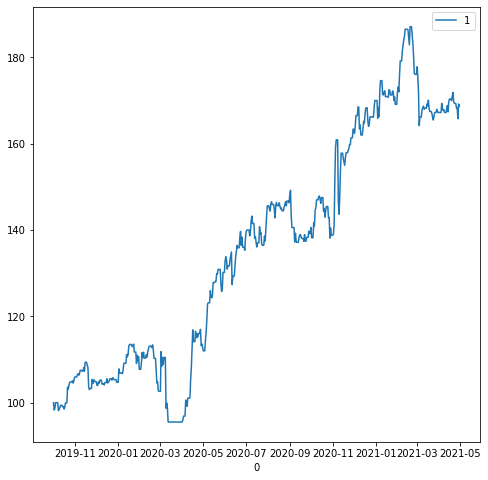

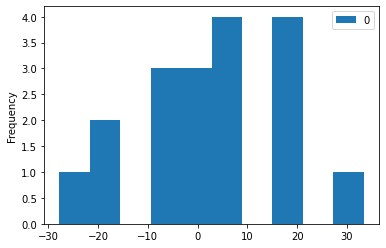

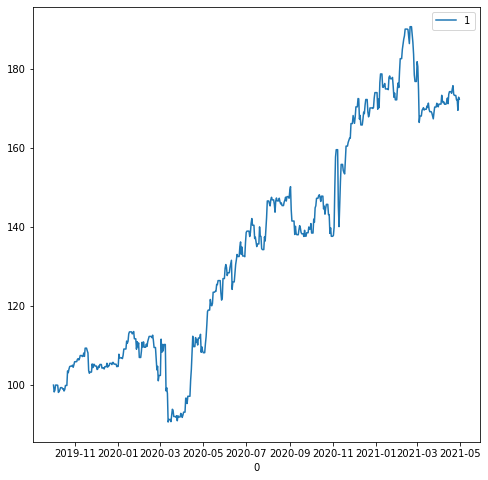

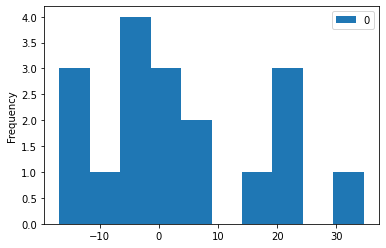

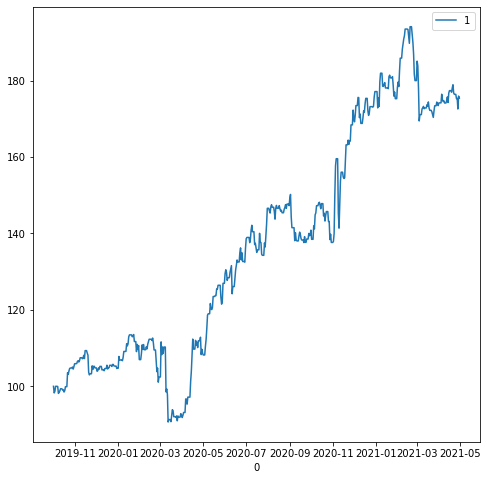

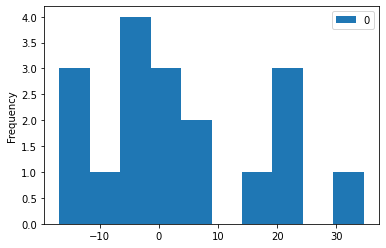

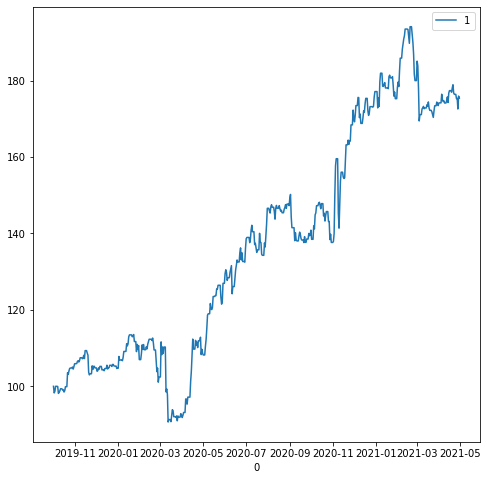

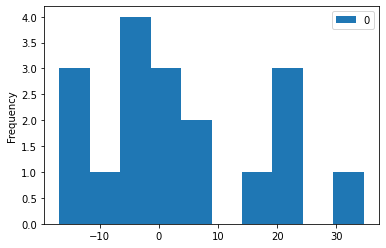

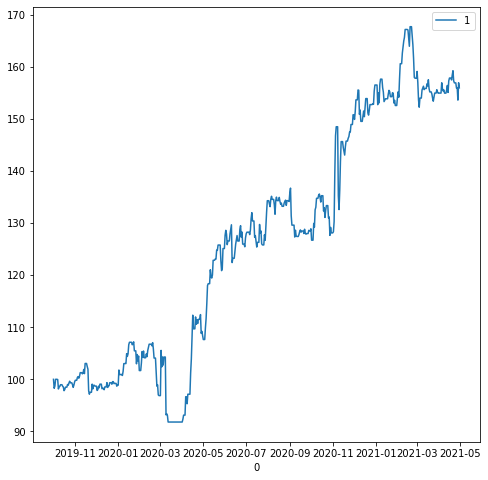

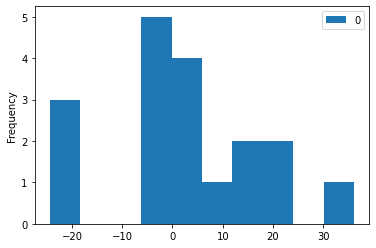

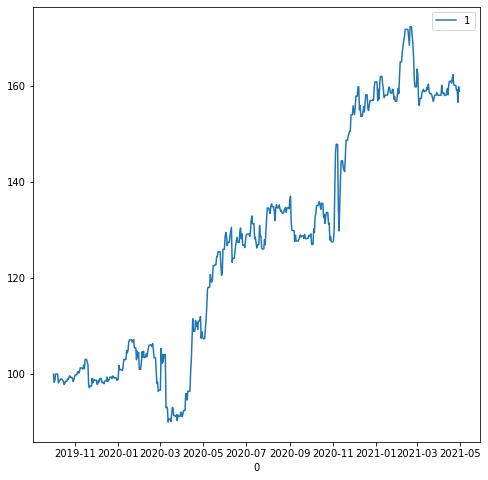

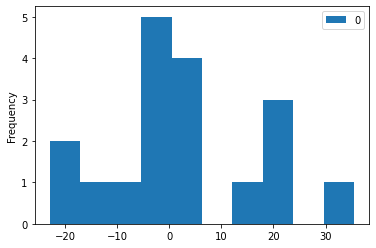

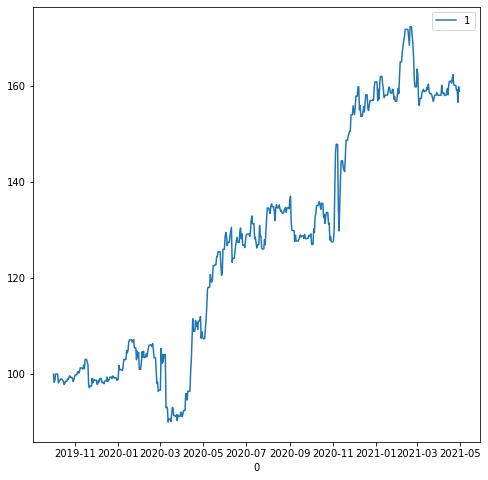

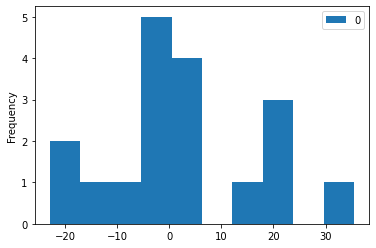

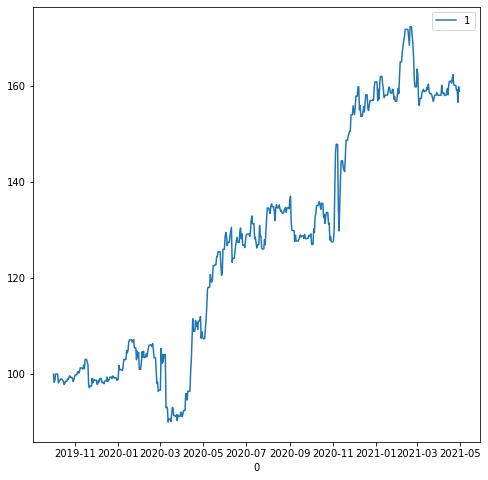

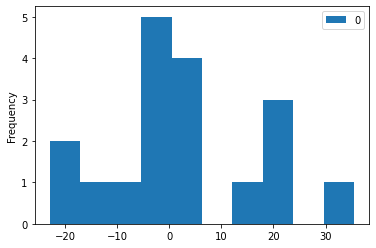

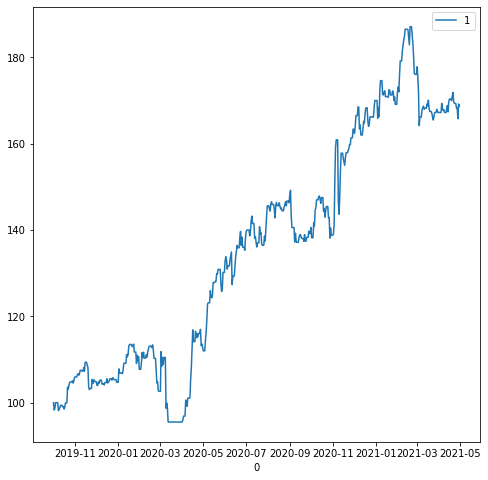

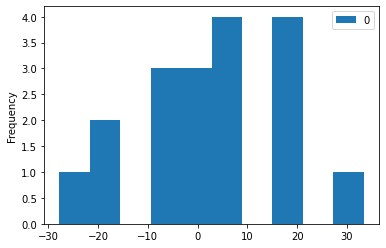

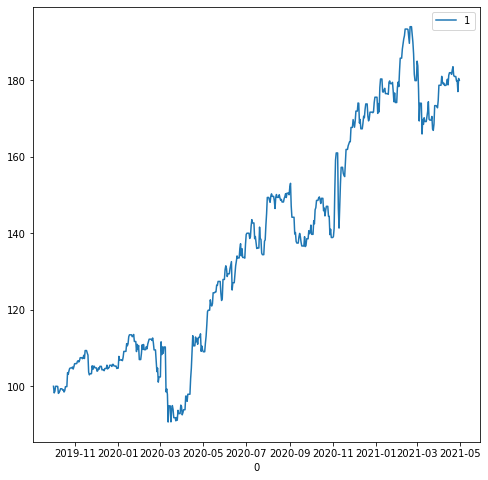

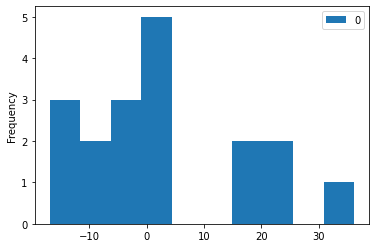

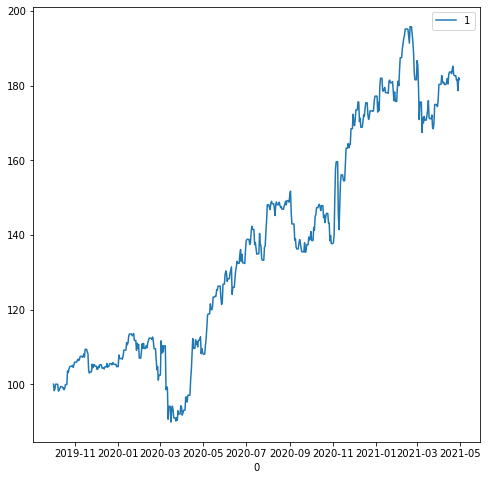

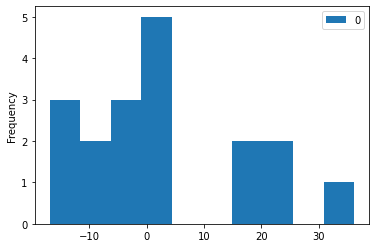

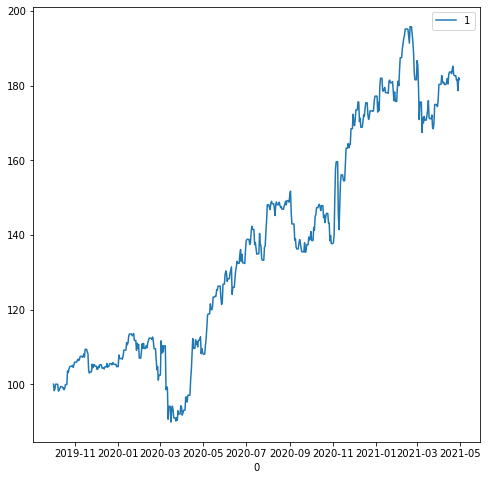

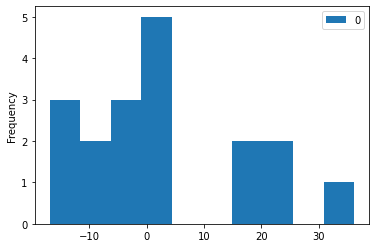

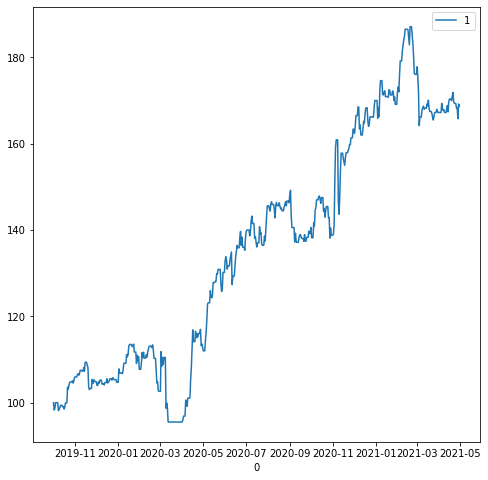

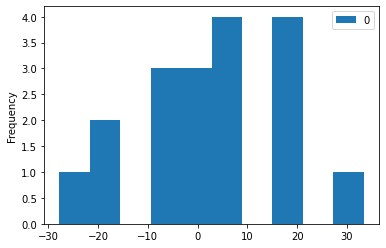

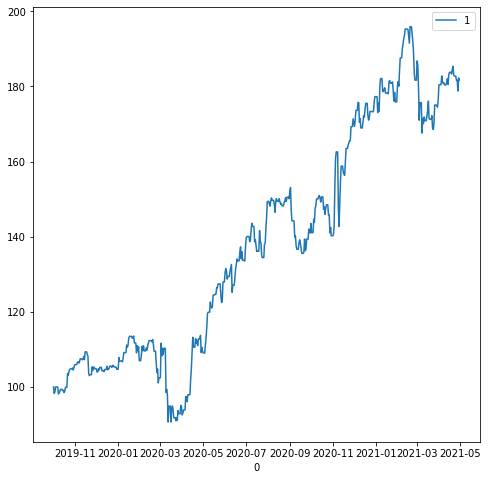

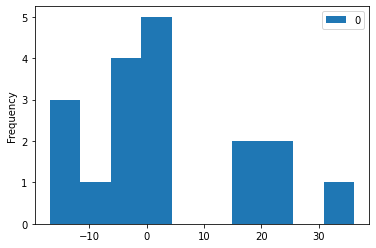

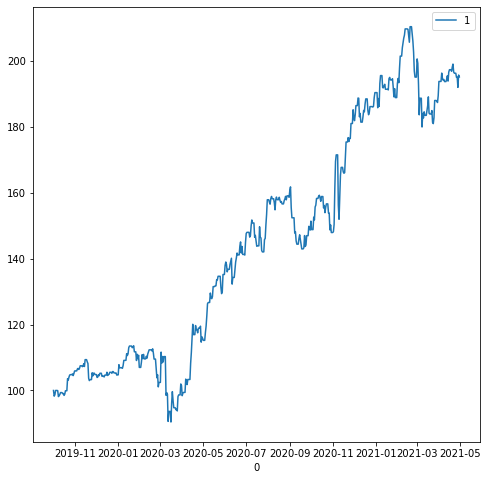

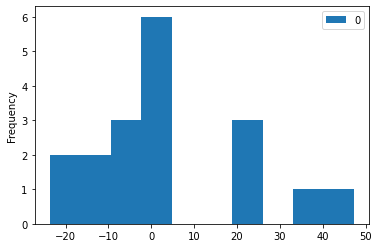

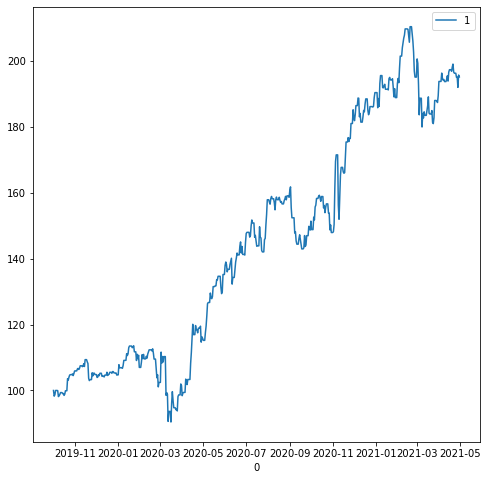

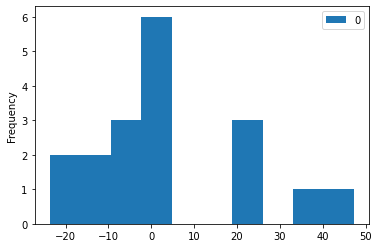

In [86]:
results = [] # (idx, balance)[]

for idx in trange(product_params_size, desc='product_params'):
    # params
    month_period = product_params[idx][0]
    num_stock_hold = product_params[idx][1]
    sell_threshold = product_params[idx][2]
    sell_ratio = product_params[idx][3]
    cut_loss_threshold = product_params[idx][4]
    stop_loss_threshold = product_params[idx][5]

    # initial vars
    total_balance = initial_balance
    latest_balance = initial_balance
    position = [0.00] * num_stocks
    state = [0] * num_stocks
    buy_at = [0.00] * num_stocks
    max_price = [0.00] * num_stocks
    selected_stock = []
    acc_total_balances = []
    month_count = 0
    trading_token = 0
    avg = 0
    profit = []

    def hit_sell_threshold(i, price, buy_price):
        return price >= buy_price * sell_threshold[i]

    def hit_cut_loss_threshold(price, buy_price):
        return price <= buy_price * cut_loss_threshold

    def hit_stop_loss_threshold(price, max_price):
        return price <= max_price * stop_loss_threshold
        
    for single_date in tqdm(list(daterange(start_date, end_date)),leave=False, desc='date'):
        date_key = to_date_key(single_date)

        # Trading period
        if single_date.day == 1:
            if month_count % month_period == 0:
                trading_token = 1
            month_count += 1

        if trading_token == 1:
            trading_token = 0
            # select stock by top tsi
            tsi_data = get_tsi_data(single_date)
            tsi_data.sort(key=lambda x:-x[1])
            top_stock = tsi_data[5: num_stock_hold + 5]
            selected_stock = list(map(lambda x : x[0], top_stock))
            if debug:
                printmd(f"Month {month_count}")
                print(list(map(lambda x : (stock_dict[x[0]], x[1]), top_stock)))

            # sell all if not top
            for i in range(num_stocks):
                price = df[i]['Close'].get(date_key) if df[i]['Close'].get(date_key) else find_nearest_price(i, single_date)
                if position[i] > 0.0 and (i not in selected_stock):
                    amount = position[i]
                    total_balance += sell(amount, price)
                    state[i] = 0
                    buy_at[i] = 0
                    max_price[i] = 0
                    position[i] = 0
                    if debug:
                        print(f"{date_key} 🧧 sell {stock_dict[i]} at: {round(price, decimal_display)}, amount: {round(amount, decimal_display)}, total_balance: {round(total_balance, decimal_display)}")
            
            if month_count != 1:
                avg += (total_balance - latest_balance) / (latest_balance * month_period) * 100
                profit.append((total_balance - latest_balance) / (latest_balance * month_period) * 100)
                latest_balance = total_balance
                
            # buy all top
            partial_balance = total_balance / num_stock_hold
            if partial_balance > 0.0:
                for i in selected_stock:
                    price = df[i]['Close'].get(date_key) if df[i]['Close'].get(date_key) else find_nearest_price(i, single_date)
                    amount = buy(partial_balance, price)
                    total_balance -= partial_balance
                    position[i] += amount
                    buy_at[i] = price
                    max_price[i] = price
                    state[i] = 0
                    if debug:
                        print(f"{date_key} 🟢 buy {stock_dict[i]} at: {round(price, decimal_display)}, amount: {round(amount, decimal_display)}, total_balance: {round(total_balance, decimal_display)}")

        # Watch stock price
        for i in selected_stock:
            price = df[i]['Close'].get(date_key) if df[i]['Close'].get(date_key) else find_nearest_price(i, single_date)
            max_price[i] = max(price, max_price[i])
            if position[i] > 0.0:
                # sell
                if state[i] < len(sell_threshold) and hit_sell_threshold(state[i], price, buy_at[i]):
                    amount = position[i] * sell_ratio[state[i]]
                    total_balance += sell(amount, price)
                    position[i] -= amount
                    state[i] += 1
                    symbol = "🔴" * state[i]
                    if debug:
                        # print(position)
                        print(f"{date_key} {symbol} sell {stock_dict[i]} at: {round(price, decimal_display)}, amount: {round(amount, decimal_display)}, total_balance: {round(total_balance, decimal_display)}")

                # stop loss
                elif hit_stop_loss_threshold(price, max_price[i]):
                    amount = position[i]
                    total_balance += sell(amount, price)
                    buy_at[i] = 0.0
                    position[i] = 0.0
                    state[i] += 1
                    if debug:
                        # print(position)
                        print(f"{date_key} 🔥 stop_loss {stock_dict[i]} at: {round(price, decimal_display)}, amount: {round(amount, decimal_display)}, total_balance: {round(total_balance, decimal_display)}")
                # cut loss
                elif hit_cut_loss_threshold(price, buy_at[i]):
                    amount = position[i]
                    total_balance += sell(amount, price)
                    # buy_at[i] = 0.0
                    position[i] = 0.0
                    state[i] += 1
                    if debug:
                        # print(position)
                        print(f"{date_key} 🔥 cut_loss {stock_dict[i]} at: {round(price, decimal_display)}, amount: {round(amount, decimal_display)}, total_balance: {round(total_balance, decimal_display)}")
        acc_total_balances.append((single_date, total_balance + calculate_position_balance(single_date)))
        # print(calculate_position_balance(single_date))

    pd.set_option('display.max_rows', 100)
    acc_total_balance_df = pd.DataFrame(acc_total_balances)
    acc_total_balance_df = acc_total_balance_df.set_index(0)
    acc_total_balance_df.plot(figsize=(8, 8))

    total_balance += calculate_position_balance(end_date)
    pd.DataFrame(profit).plot.hist(bins=10)
    avg *= 12 / month_count

    # Saving results
    results.append((idx, total_balance, avg))

    if debug: print("-------- 📈 Summary --------")
    print(f"{idx} -> total balance: {round(total_balance, decimal_display)}, avg: {avg}")

In [87]:
results.sort(key=lambda x:x[2], reverse=True)
for result in results[:5]:
    idx = result[0]
    avg = result[2]
    params = product_params[idx]

    month_period = params[0]
    num_stock_hold = params[1]
    sell_threshold = params[2]
    sell_ratio = params[3]
    cut_loss_threshold = params[4]
    stop_loss_threshold = params[5]

    print(f"{idx}   total balance : {round(result[1], 100)}")
    print(f"        average_per_period: {avg}")
    print(f"        month_period: {month_period}")
    print(f"        num_stock_hold: {num_stock_hold}")
    print(f"        sell_threshold: {sell_threshold}")
    print(f"        sell_ratio: {sell_ratio}")
    print(f"        cut_loss_threshold: {cut_loss_threshold}")
    print(f"        stop_loss_threshold: {stop_loss_threshold}")
    print()

14   total balance : 195.07593137403205
        average_per_period: 46.810729027639184
        month_period: 1
        num_stock_hold: 5
        sell_threshold: [1.25, 1.5, 1.75]
        sell_ratio: [0.2, 0.3, 0.4]
        cut_loss_threshold: 0.8
        stop_loss_threshold: 0.7

15   total balance : 195.07593137403205
        average_per_period: 46.810729027639184
        month_period: 1
        num_stock_hold: 5
        sell_threshold: [1.25, 1.5, 1.75]
        sell_ratio: [0.2, 0.3, 0.4]
        cut_loss_threshold: 0.8
        stop_loss_threshold: 0.6

10   total balance : 181.60804147076388
        average_per_period: 36.06921856479031
        month_period: 1
        num_stock_hold: 5
        sell_threshold: [1.25, 1.5, 1.75]
        sell_ratio: [0.2, 0.3, 0.4]
        cut_loss_threshold: 0.85
        stop_loss_threshold: 0.7

11   total balance : 181.60804147076388
        average_per_period: 36.06921856479031
        month_period: 1
        num_stock_hold: 5
        sell_threshol